# SoftmaxLoss

Let's try `SoftmaxLoss` with different batch size and learning rate.


In [1]:
import pickle

import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
from ptls.preprocessing import PandasDataPreprocessor

In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [4]:
from glob import glob

In [5]:
import ptls.data_load
import ptls.data_load.datasets
import ptls.frames
import ptls.frames.coles
import ptls.frames.inference_module
import ptls.nn

In [6]:
import torch

In [7]:
from functools import partial

In [8]:
import pytorch_lightning as pl

In [9]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [10]:
import datetime

In [11]:
def get_norm(df):
    values = torch.cat(list(rec['amount_rur'] for rec in df))
    values = values.sign() * values.abs().log1p()
    m = values.mean().item()
    s = values.std().item()
    return m, s

In [12]:
class LogScaler(ptls.nn.trx_encoder.scalers.IdentityScaler):
    def __init__(self, m, s):
        super().__init__()
        self.m = m
        self.s = s
        
    def forward(self, x):
        x = super().forward(x)
        return (x.abs().log1p() * x.sign() - self.m) / self.s

    @property
    def output_size(self):
        return 1

In [13]:
params = [
    (fold_i, hidden_size, max_steps, batch_size, temperature, lr)
    for fold_i in [0]
    for hidden_size in [800]
    for max_steps in [100000]
    for batch_size in [128] # [32, 64, 128, 256, 512]
    for temperature in [0.05]
    for lr in [0.003, 0.01, 0.0003, 0.0001]  # 0.001, 
    # for train_size in [1200]
    # for train_size in [1200, 2500, 5000, 10000, 20000, 40000]
] + [
    (fold_i, hidden_size, max_steps, batch_size, temperature, lr)
    for fold_i in [1, 2]
    for hidden_size in [800]
    for max_steps in [100000]
    for batch_size in [64, 128] # [32, 64, 128, 256, 512]
    for temperature in [0.05]
    for lr in [0.003, 0.01, 0.0003, 0.0001]  # 0.001, 
    # for train_size in [1200]
    # for train_size in [1200, 2500, 5000, 10000, 20000, 40000]
]

In [ ]:
MODEL_NAME='04_coles_softmax'

for fold_i, hidden_size, max_steps, batch_size, temperature, p_lr in params:

    df_trx_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_trx_pretrain.pickle')
    df_seq_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_seq_pretrain.pickle')
    df_gbm_train = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_train.pickle')
    df_gbm_test = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_test.pickle')

    with open(f'data/fold_{fold_i}/pdp.pickle', 'rb') as f:
        pdp = pickle.load(f)

    df_seq_pretrain_train, df_seq_pretrain_valid = train_test_split(
        df_seq_pretrain, test_size=0.05, shuffle=True, random_state=42)

    full_train = df_seq_pretrain_train.to_dict(orient='records') +\
    df_trx_pretrain.to_dict(orient='records')
    
    coles_data_module = ptls.frames.PtlsDataModule(
        train_data=ptls.frames.coles.ColesDataset(
            data=ptls.data_load.datasets.MemoryMapDataset(
                # full_train[:train_size] * int(40000 / train_size)
                full_train,
            ),
            splitter=ptls.frames.coles.split_strategy.SampleSlices(
                split_count=5,
                cnt_min=25,
                cnt_max=200,
            ),
        ),
        valid_data=ptls.frames.coles.ColesDataset(
            data=ptls.data_load.datasets.MemoryMapDataset(
                df_seq_pretrain_train.to_dict(orient='records')),
            splitter=ptls.frames.coles.split_strategy.SampleSlices(
                split_count=5,
                cnt_min=25,
                cnt_max=100,
            ),
        ),
        # train_batch_size=64,
        train_batch_size=batch_size,
        train_num_workers=4,
        valid_batch_size=650,
    )

    pl_coles_module = ptls.frames.coles.CoLESModule(
        validation_metric=ptls.frames.coles.metric.BatchRecallTopK(
            K=4,
            metric='cosine',
        ),
        seq_encoder=torch.nn.Sequential(
            ptls.nn.TrxEncoder(
                norm_embeddings=False,
                embeddings_noise=0.003,
                use_batch_norm=False,
                embeddings={
                    'weekday': {'in': 10, 'out': 8},
                    'small_group': {'in': 250, 'out': 16},
                    'event_time': {'in': 800, 'out': 8},
                },
                numeric_values={ 
                    # 'amount_rur': 'identity',
                    # 'amount_rur': 'log',
                    'amount_rur': LogScaler(*get_norm(full_train)),
                },
            ),
            ptls.nn.RnnEncoder(
                # input_size=25,
                input_size=33,
                type='gru',
                hidden_size=hidden_size,
                is_reduce_sequence=True,
            ),
        ),
        head=ptls.nn.Head(use_norm_encoder=True),
        # loss=ptls.frames.coles.losses.ContrastiveLoss(
        #     margin=0.5,
        #     sampling_strategy=ptls.frames.coles.sampling_strategies.HardNegativePairSelector(
        #       neg_count=5,
        #     ),
        # ),
        loss=ptls.frames.coles.losses.SoftmaxLoss(
            temperature=temperature,
        ),
        optimizer_partial=partial(torch.optim.Adam, lr=p_lr, weight_decay=0.0),
        lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9025)
    )

    model_checkpoint = pl.callbacks.ModelCheckpoint(
        save_top_k=-1, 
        save_weights_only=True, 
        every_n_train_steps=5000,
    )
    
    trainer = pl.Trainer(
        gpus=1,
        max_steps=max_steps,
        check_val_every_n_epoch=5,
        log_every_n_steps=200,
        max_epochs=20000, # 150,
        # enable_checkpointing=False,
        enable_progress_bar=False,
        gradient_clip_val=0.5,
        gradient_clip_algorithm="value",
        callbacks=[
            model_checkpoint,
        ],
    )   

    pretrain_logger_version = trainer.logger.version
    print(f'pretrain_logger_version = {pretrain_logger_version}')
    trainer.fit(pl_coles_module, coles_data_module)

    for train_steps in [
        10000, 20000, 30000, 40000, 50000,
        60000, 70000, 80000, 90000, 100000,
    ]:
        ckpt_path = glob(model_checkpoint.dirpath + f'/*-step={train_steps}.ckpt')[0]
        pl_coles_module.load_state_dict(torch.load(ckpt_path)['state_dict'])
        
        inference_dl_gbm_train = torch.utils.data.DataLoader(
            dataset=ptls.data_load.datasets.MemoryMapDataset(
                df_gbm_train.to_dict(orient='records'),
                i_filters=[
                    ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
                ],
            ),
            collate_fn=ptls.data_load.utils.collate_feature_dict,
            shuffle=False,
            batch_size=1000,
            num_workers=12,
        )

        inference_dl_gbm_test = torch.utils.data.DataLoader(
            dataset=ptls.data_load.datasets.MemoryMapDataset(
                df_gbm_test.to_dict(orient='records'),
                i_filters=[
                    ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
                ],
            ),
            collate_fn=ptls.data_load.utils.collate_feature_dict,
            shuffle=False,
            batch_size=1000,
            num_workers=12,
        )

        inf_model = ptls.frames.inference_module.InferenceModule(
            model=pl_coles_module.seq_encoder, pandas_output=True, model_out_name='emb')

        predict_gbm_train = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
        .predict(inf_model, inference_dl_gbm_train)

        predict_gbm_test = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
        .predict(inf_model, inference_dl_gbm_test)

        predict_gbm_train = pd.concat(predict_gbm_train, axis=0)

        predict_gbm_test = pd.concat(predict_gbm_test, axis=0)

        predict_gbm_train.set_index('client_id', inplace=True)
        predict_gbm_test.set_index('client_id', inplace=True)

        gbm_model = LGBMClassifier(**{
              'n_estimators': 1000,
              'boosting_type': 'gbdt',
              'objective': 'multiclass',
              'num_class': 4,
              'metric': 'multi_error',
              'learning_rate': 0.02,
              'subsample': 0.75,
              'subsample_freq': 1,
              'feature_fraction': 0.75,
              'colsample_bytree': None,
              'max_depth': 12,
              'lambda_l1': 1,
              'reg_alpha': None,
              'lambda_l2': 1,
              'reg_lambda': None,
              'min_data_in_leaf': 50,
              'min_child_samples': None,
              'num_leaves': 50,
              'random_state': 42,
              'n_jobs': 4,
        })

        gbm_model.fit(predict_gbm_train.drop(columns='bins'), predict_gbm_train['bins'])

        acc = accuracy_score(
            gbm_model.predict(predict_gbm_test.drop(columns='bins')), 
            predict_gbm_test['bins'],
        )
        acc

        with open('results-softmax.log', 'at') as f:
            print('\t'.join([
                MODEL_NAME,
                f'{datetime.datetime.now():%Y-%m-%d %H:%M:%S}',
                f'{fold_i}',
                'accuracy',
                f'{acc:.4f}',
                f'{pretrain_logger_version}',
                f'{hidden_size}',
                f'{train_steps}',
                f'{batch_size}',
                f'{temperature}',
                f'{p_lr}',
        ]), file=f)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


pretrain_logger_version = 23


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | SoftmaxLoss     | 0     
1 | _seq_encoder       | Sequential      | 2.0 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.061     Total estimated model params size (MB)
/home/jovyan/.local/share/virtualenvs/ptls-experiments-Evn9g0Hu/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

pretrain_logger_version = 24


In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ptls.tb_interface import get_scalars

In [166]:
df_res = pd.read_csv(
    # 'results.log',
    'results-softmax.log',
    sep='\t', header=None,
    names=['model', 'time', 'fold_i', 'metric', 'value',
           'pretrain_logger_version', 'hidden_size', 'train_steps', 'batch_size',
          'temperature', 'lr']
)
df_res.tail(10)

model                 time  fold_i    metric   value  \
410  04_coles_softmax  2024-02-20 04:51:12       2  accuracy  0.5897   
411  04_coles_softmax  2024-02-20 05:01:32       2  accuracy  0.5982   
412  04_coles_softmax  2024-02-20 05:07:55       2  accuracy  0.6112   
413  04_coles_softmax  2024-02-20 05:14:12       2  accuracy  0.6122   
414  04_coles_softmax  2024-02-20 05:20:29       2  accuracy  0.6070   
415  04_coles_softmax  2024-02-20 05:26:43       2  accuracy  0.6082   
416  04_coles_softmax  2024-02-20 05:33:00       2  accuracy  0.6087   
417  04_coles_softmax  2024-02-20 05:39:19       2  accuracy  0.6152   
418  04_coles_softmax  2024-02-20 05:45:40       2  accuracy  0.6093   
419  04_coles_softmax  2024-02-20 05:52:06       2  accuracy  0.6065   

     pretrain_logger_version  hidden_size  train_steps  batch_size  \
410                       44          800        10000         128   
411                       44          800        20000         128   
412                       44          800        30000         128   
413                       44          800        40000         128   
414                       44          800        50000         128   
415                       44          800        60000         128   
416                       44          800        70000         128   
417                       44          800        80000         128   
418                       44          800        90000         128   
419                       44          800       100000         128   

     temperature      lr  
410         0.05  0.0001  
411         0.05  0.0001  
412         0.05  0.0001  
413         0.05  0.0001  
414         0.05  0.0001  
415         0.05  0.0001  
416         0.05  0.0001  
417         0.05  0.0001  
418         0.05  0.0001  
419         0.05  0.0001

In [167]:
df_res.groupby(['batch_size', 'lr', 'train_steps'])['fold_i'].agg(list).unstack()

train_steps           10000      20000      30000      40000      50000   \
batch_size lr                                                              
16         0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
32         0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
64         0.0001  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0003  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0030  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0100  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
128        0.0001  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0003  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0030  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
           0.0100  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
256        0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   
512        0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]   

train_steps           60000      70000      80000      90000      100000  
batch_size lr                                                             
16         0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
32         0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
64         0.0001  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0003  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0030  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0100  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
128        0.0001  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0003  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0030  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
           0.0100  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
256        0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  
512        0.0010  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]  [0, 1, 2]

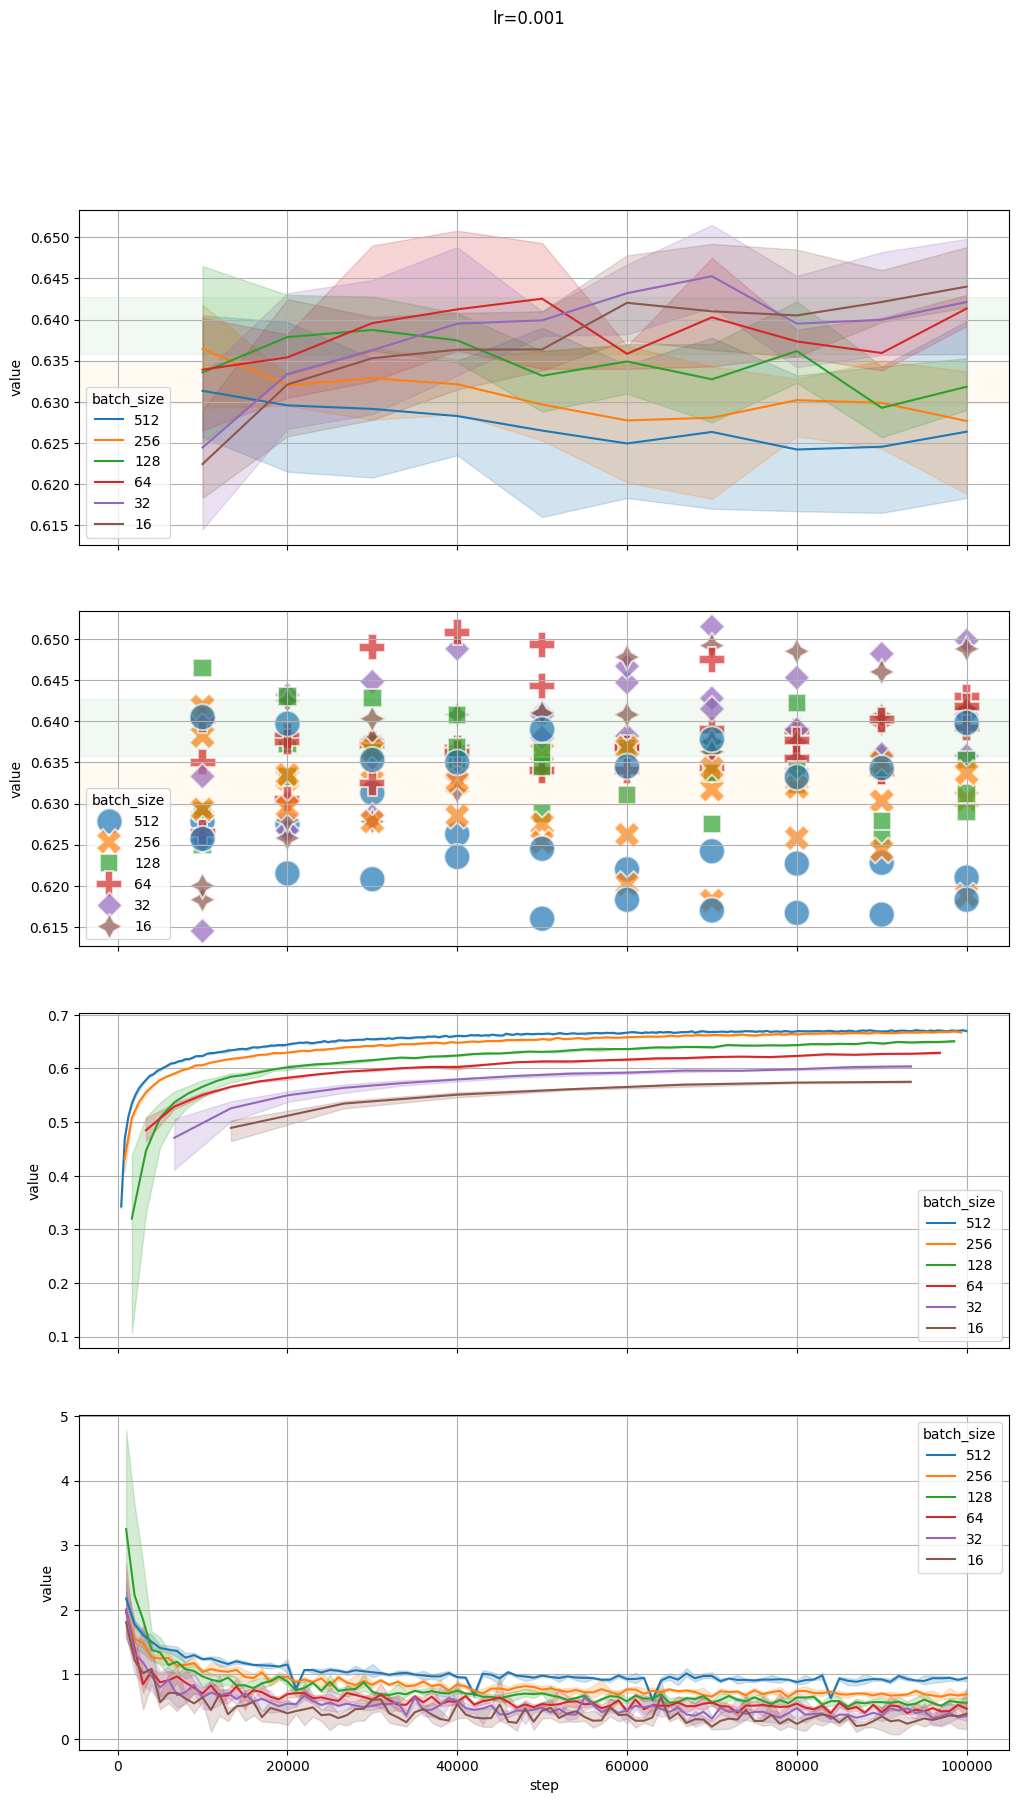

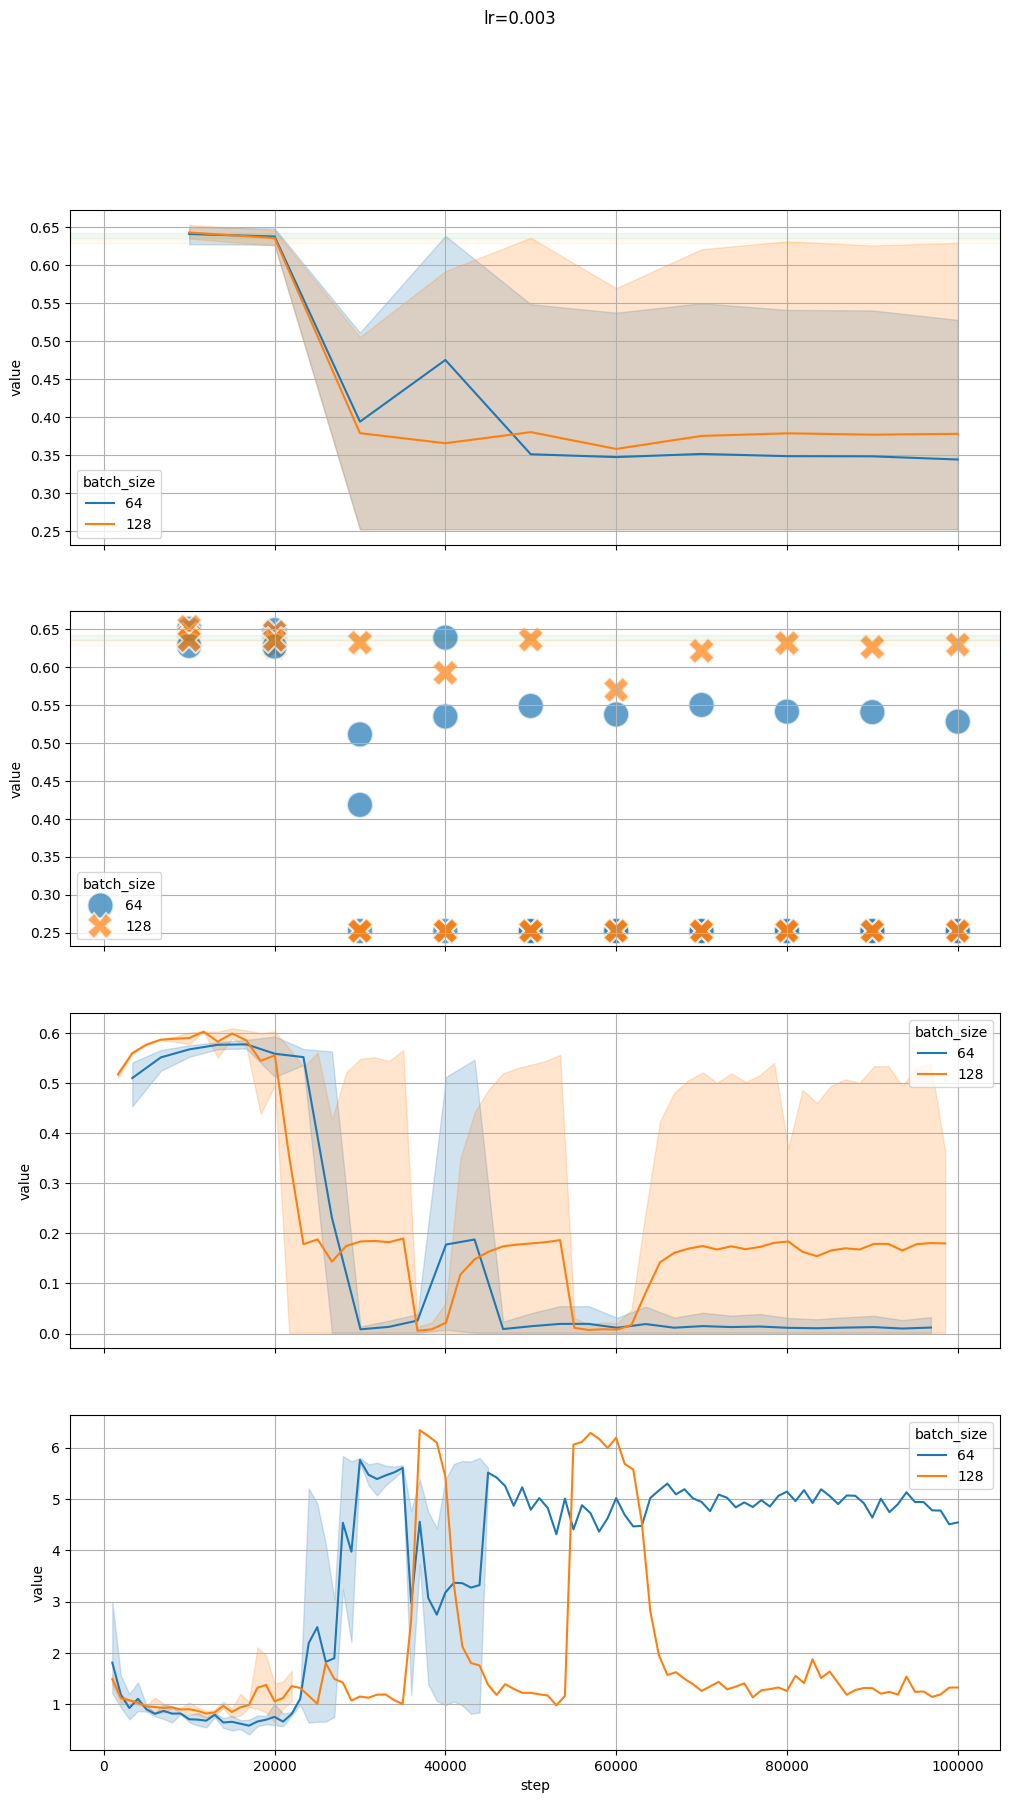

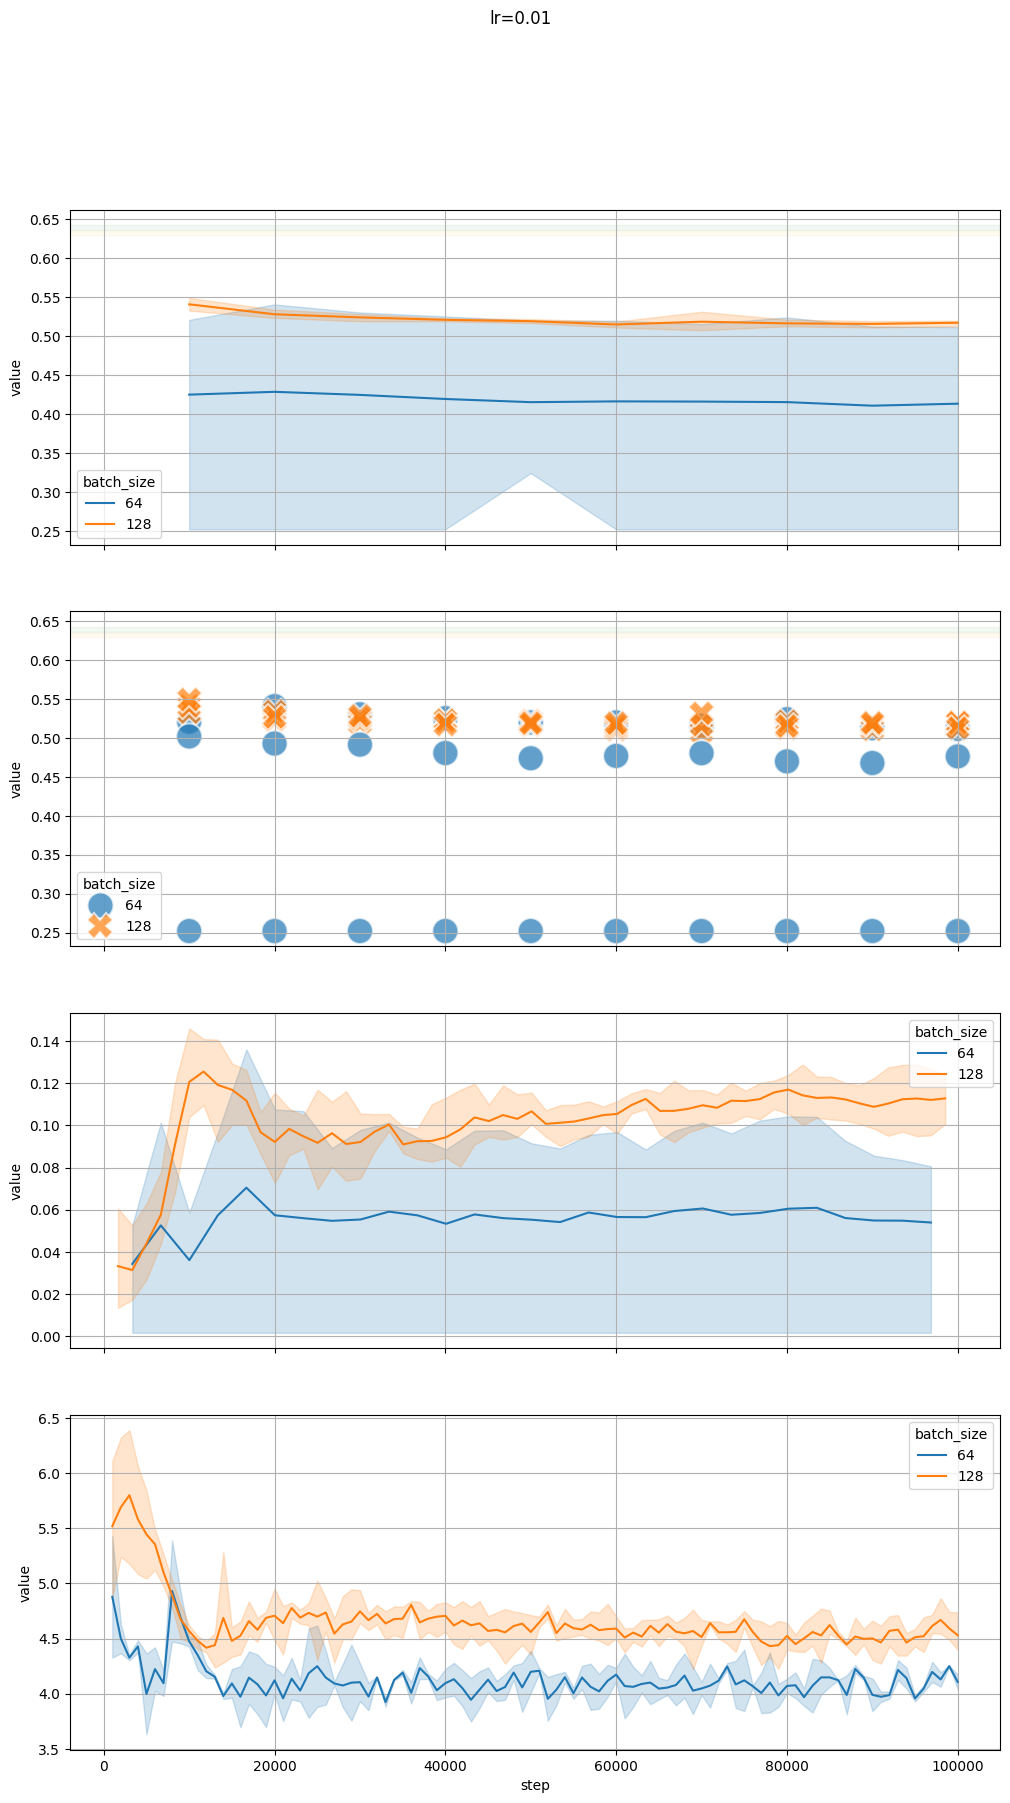

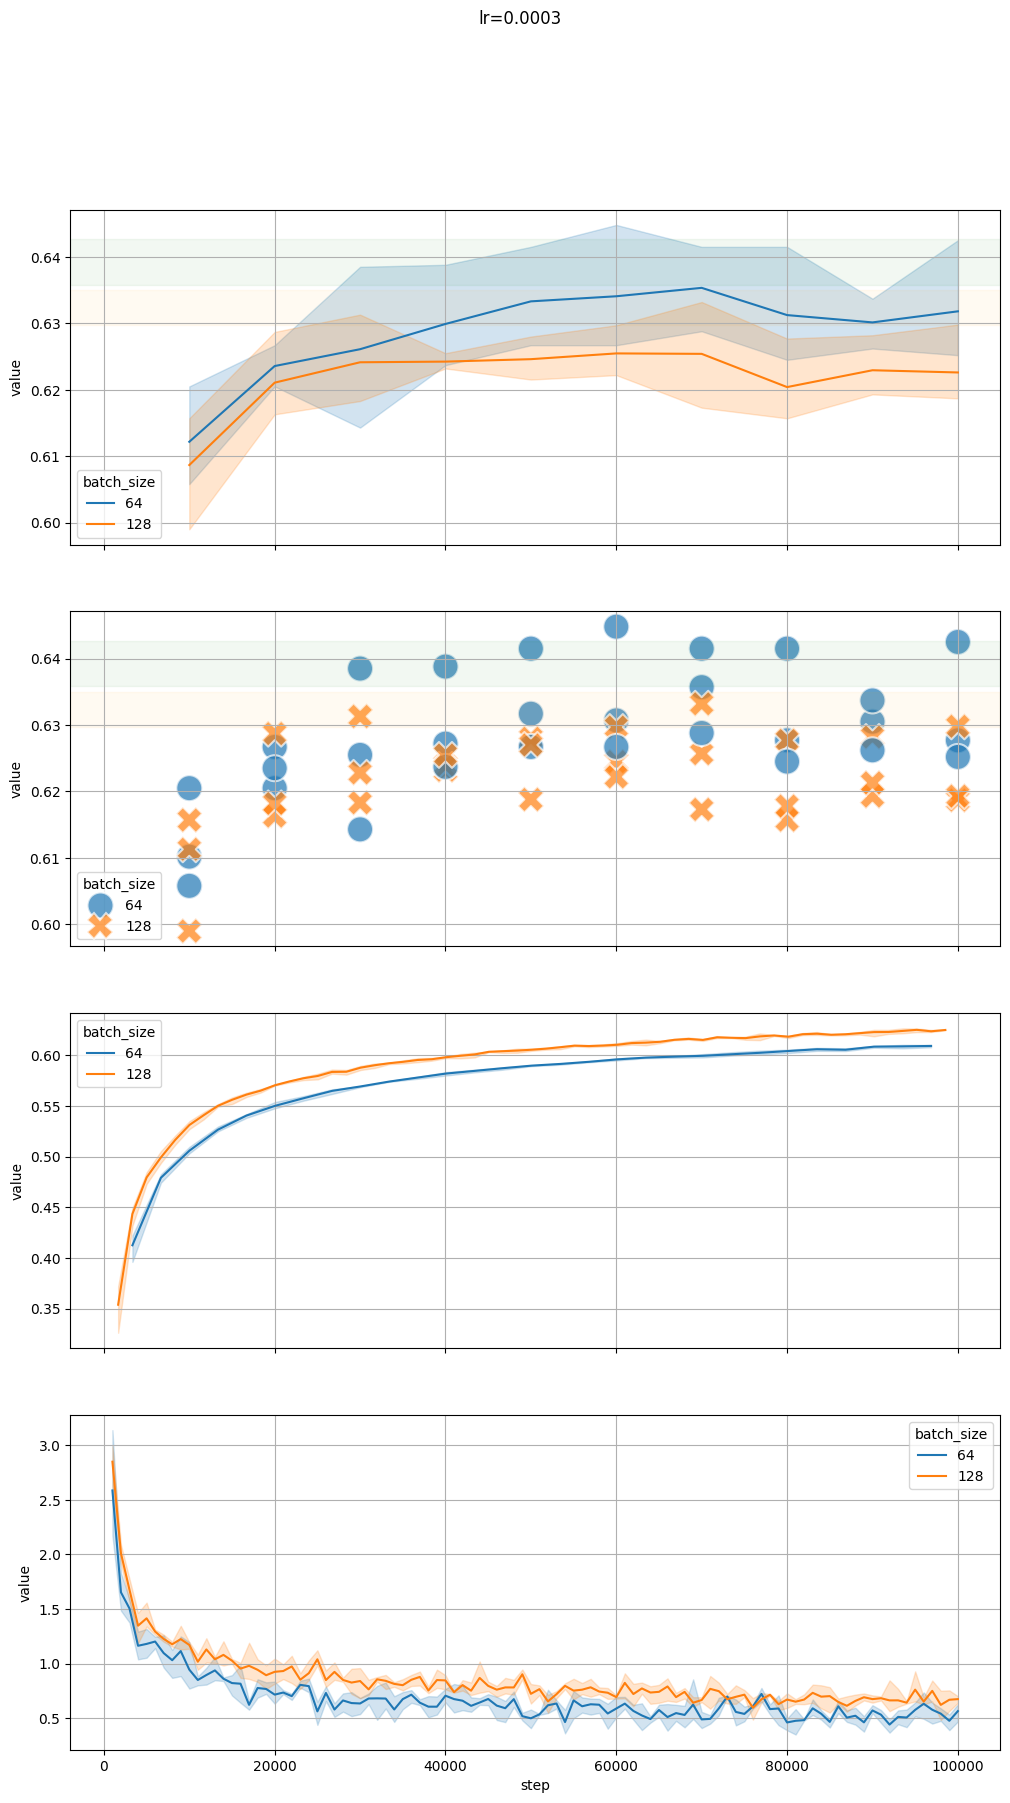

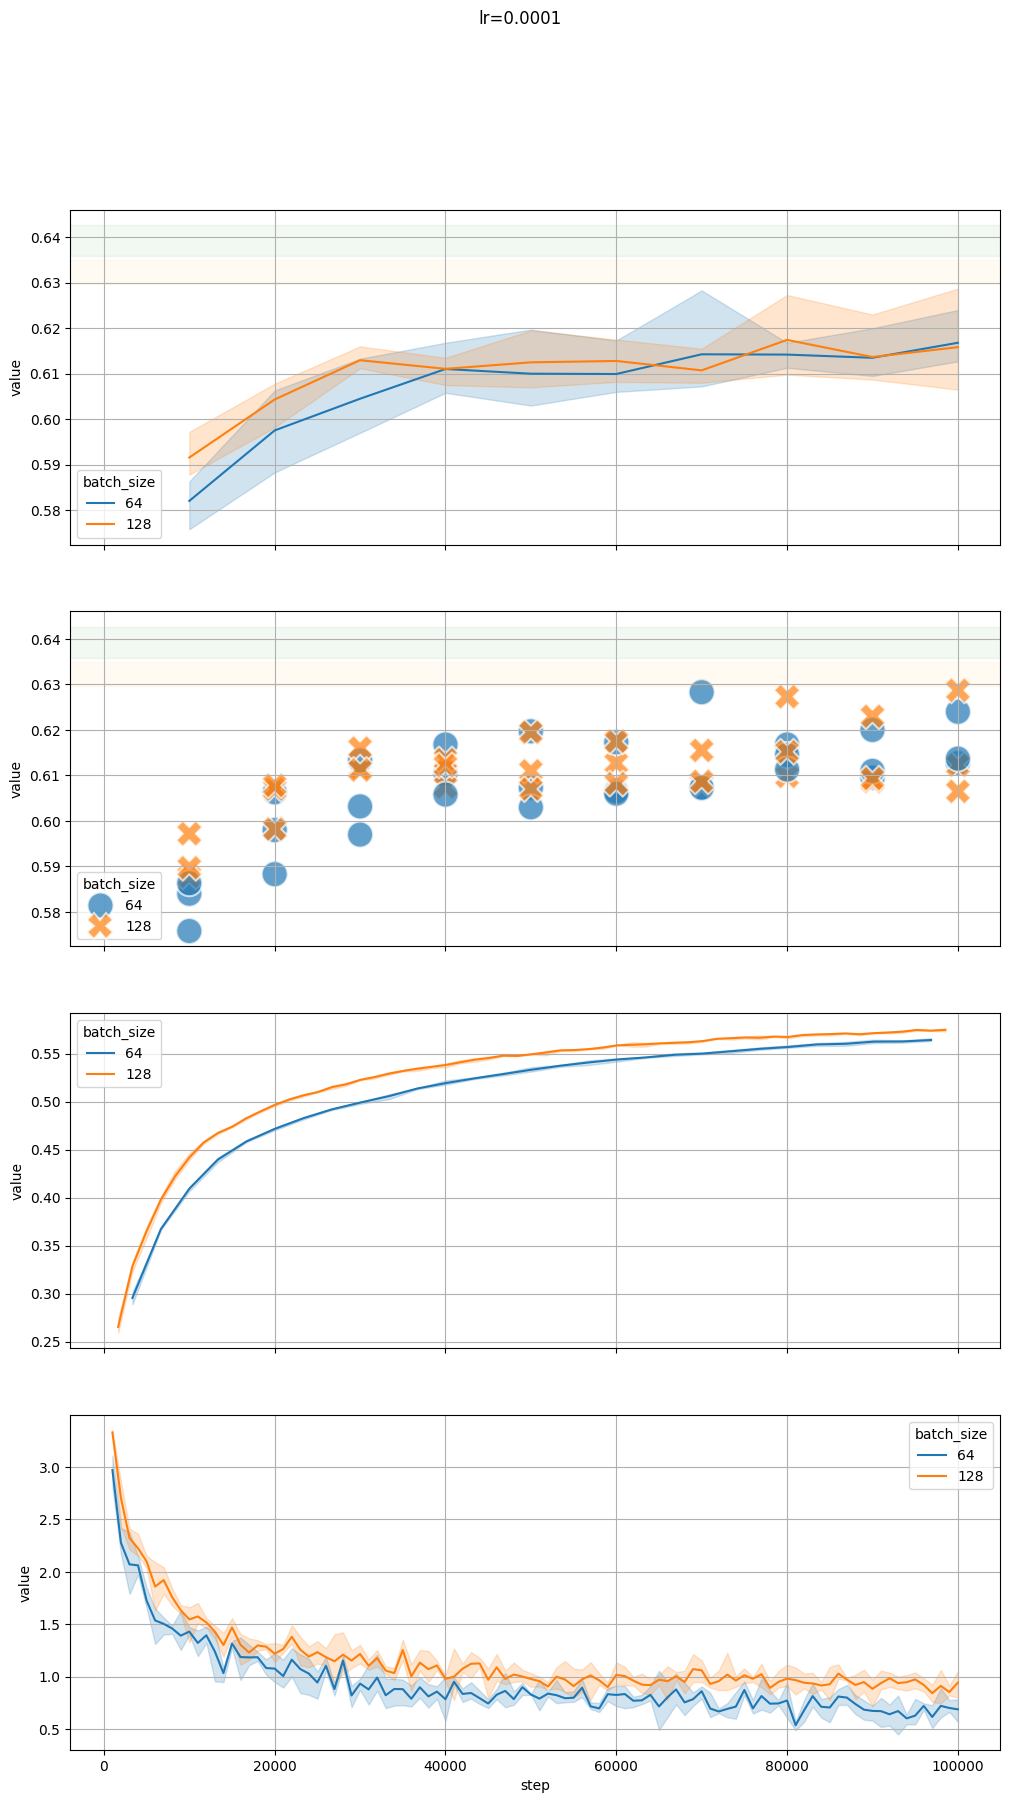

In [168]:
df_tb = get_scalars('lightning_logs/')
df_tb = df_tb[lambda x: 
              x['tag'].eq('valid/recall_top_k') | 
              x['tag'].eq('loss') & ((x['step'] + 1) % 1000 == 0)]
    
for lr in df_res['lr'].unique():
    _, axs = plt.subplots(4, 1, figsize=(12, 5 * 4), sharex=True)
    sns.lineplot(
        data=df_res[lambda x: x['lr'].eq(lr)]
        .assign(batch_size=lambda x: x['batch_size'].astype(str)),
        x='train_steps',
        y='value',
        hue='batch_size',# palette=plt.get_cmap('tab10'),
        ax=axs[0],
    )
    sns.scatterplot(
        data=df_res
        [lambda x: x['lr'].eq(lr)]
        .assign(batch_size=lambda x: x['batch_size'].astype(str)),
        x='train_steps',
        y='value',
        # marker="d",
        hue='batch_size', #palette=plt.get_cmap('tab10'),
        style='batch_size',
        # c='k',
        s=350, alpha=0.7,
        ax=axs[1],
    )
    for ax in axs[:2]:
        ax.axhspan(ymin=0.6297, ymax=0.6350, alpha=0.05, color='orange')
        ax.axhspan(ymin=0.6358, ymax=0.6427, alpha=0.05, color='green')
        # ax.axhspan(ymin=0.3845, ymax=0.3872, alpha=0.1, color='red')

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['lr'].eq(lr)]
            .groupby('pretrain_logger_version', as_index=False)['batch_size'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'batch_size']],
            df_tb[lambda x: x['tag'].eq('valid/recall_top_k')],
            on='version',
        ).assign(batch_size=lambda x: x['batch_size'].astype(str)),
        x='step',
        y='value',
        hue='batch_size',# palette=plt.get_cmap('tab10'),
        ax=axs[2],
    )

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['lr'].eq(lr)]
            .groupby('pretrain_logger_version', as_index=False)['batch_size'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'batch_size']],
            df_tb[lambda x: x['tag'].eq('loss')],  # [lambda x: (x['step'] + 1) % 1000 == 0]
            on='version',
        ).assign(batch_size=lambda x: x['batch_size'].astype(str)),
        x='step',
        y='value',
        hue='batch_size',# palette=plt.get_cmap('tab10'),
        ax=axs[3],
    )
    for ax in axs:
        ax.grid()
        
    plt.suptitle(f'lr={lr}')
    plt.show()


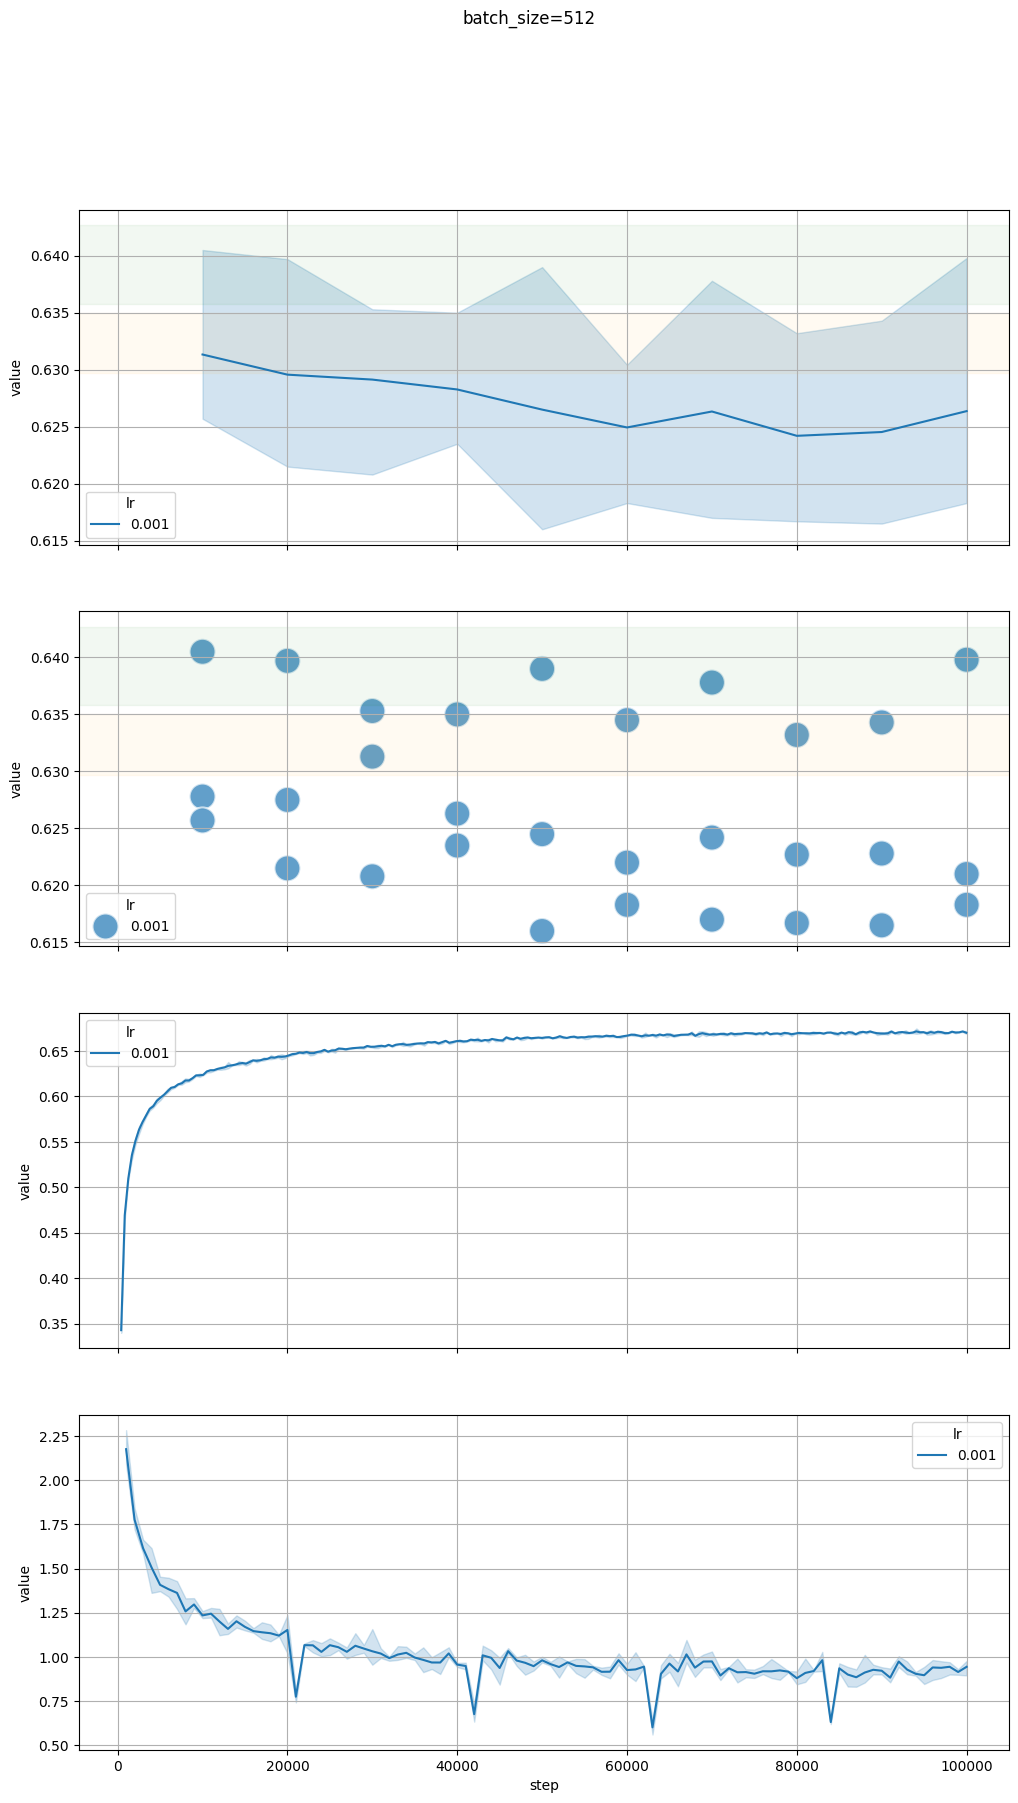

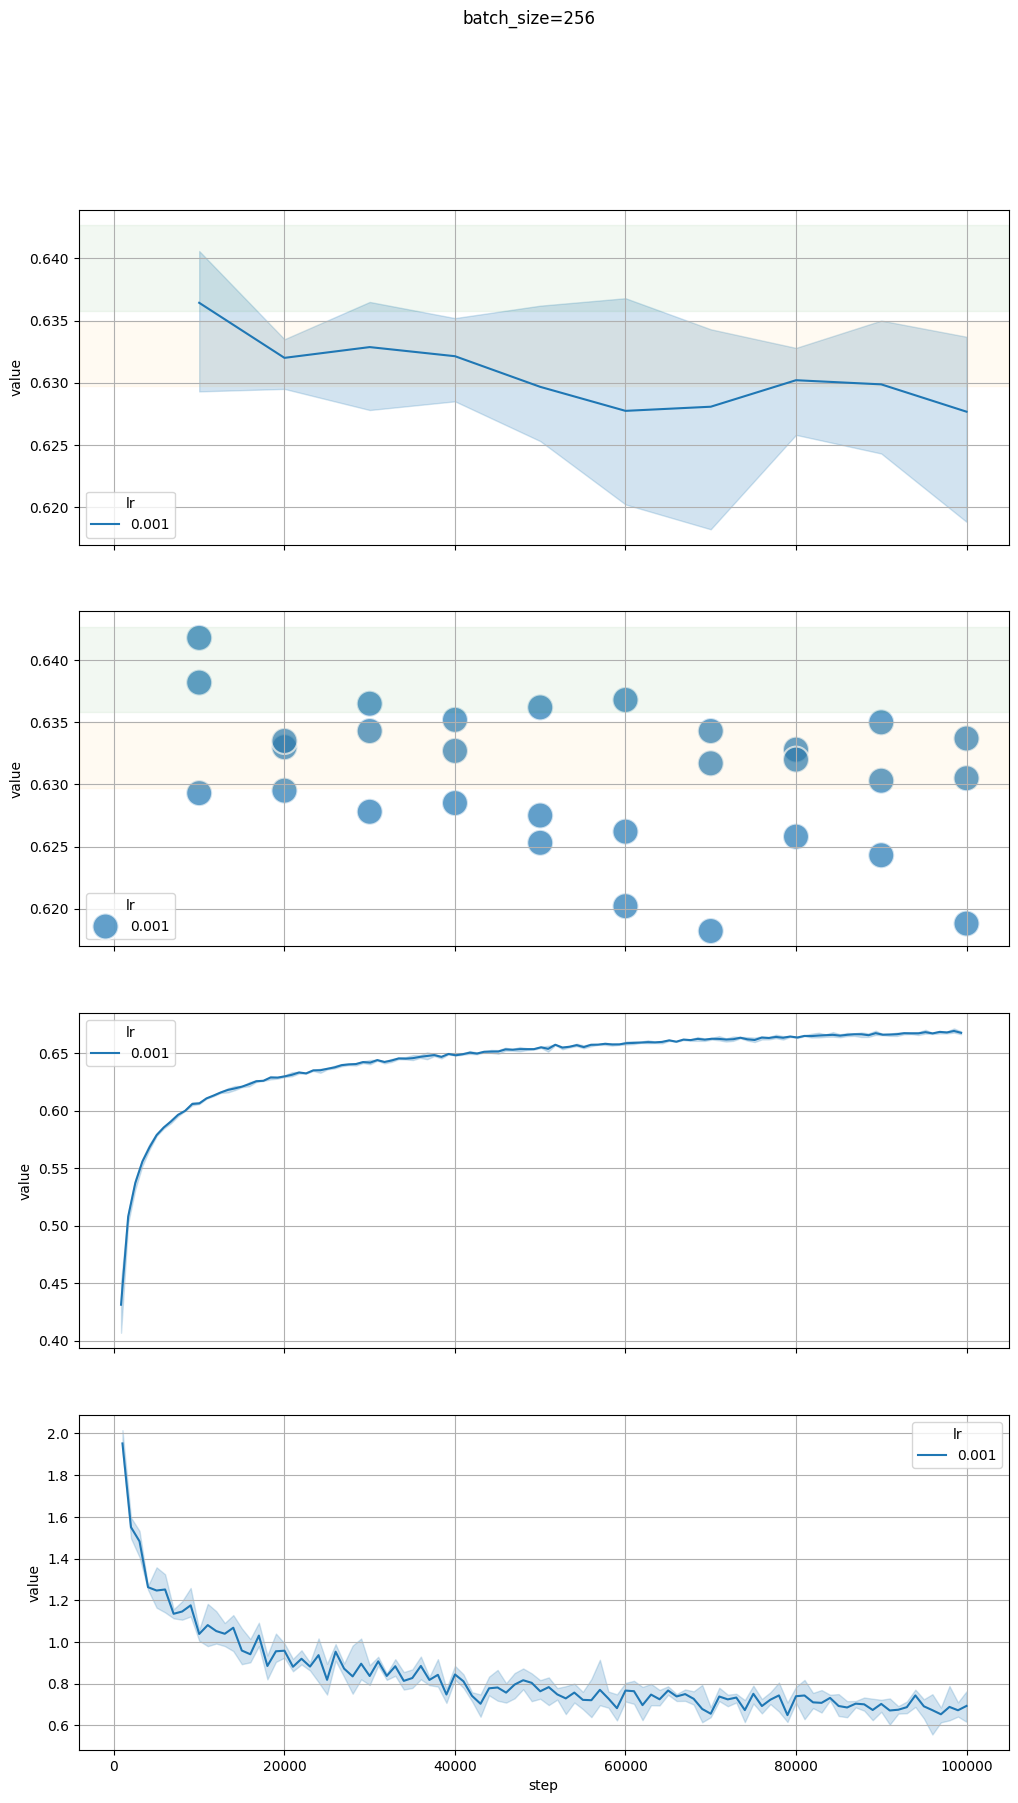

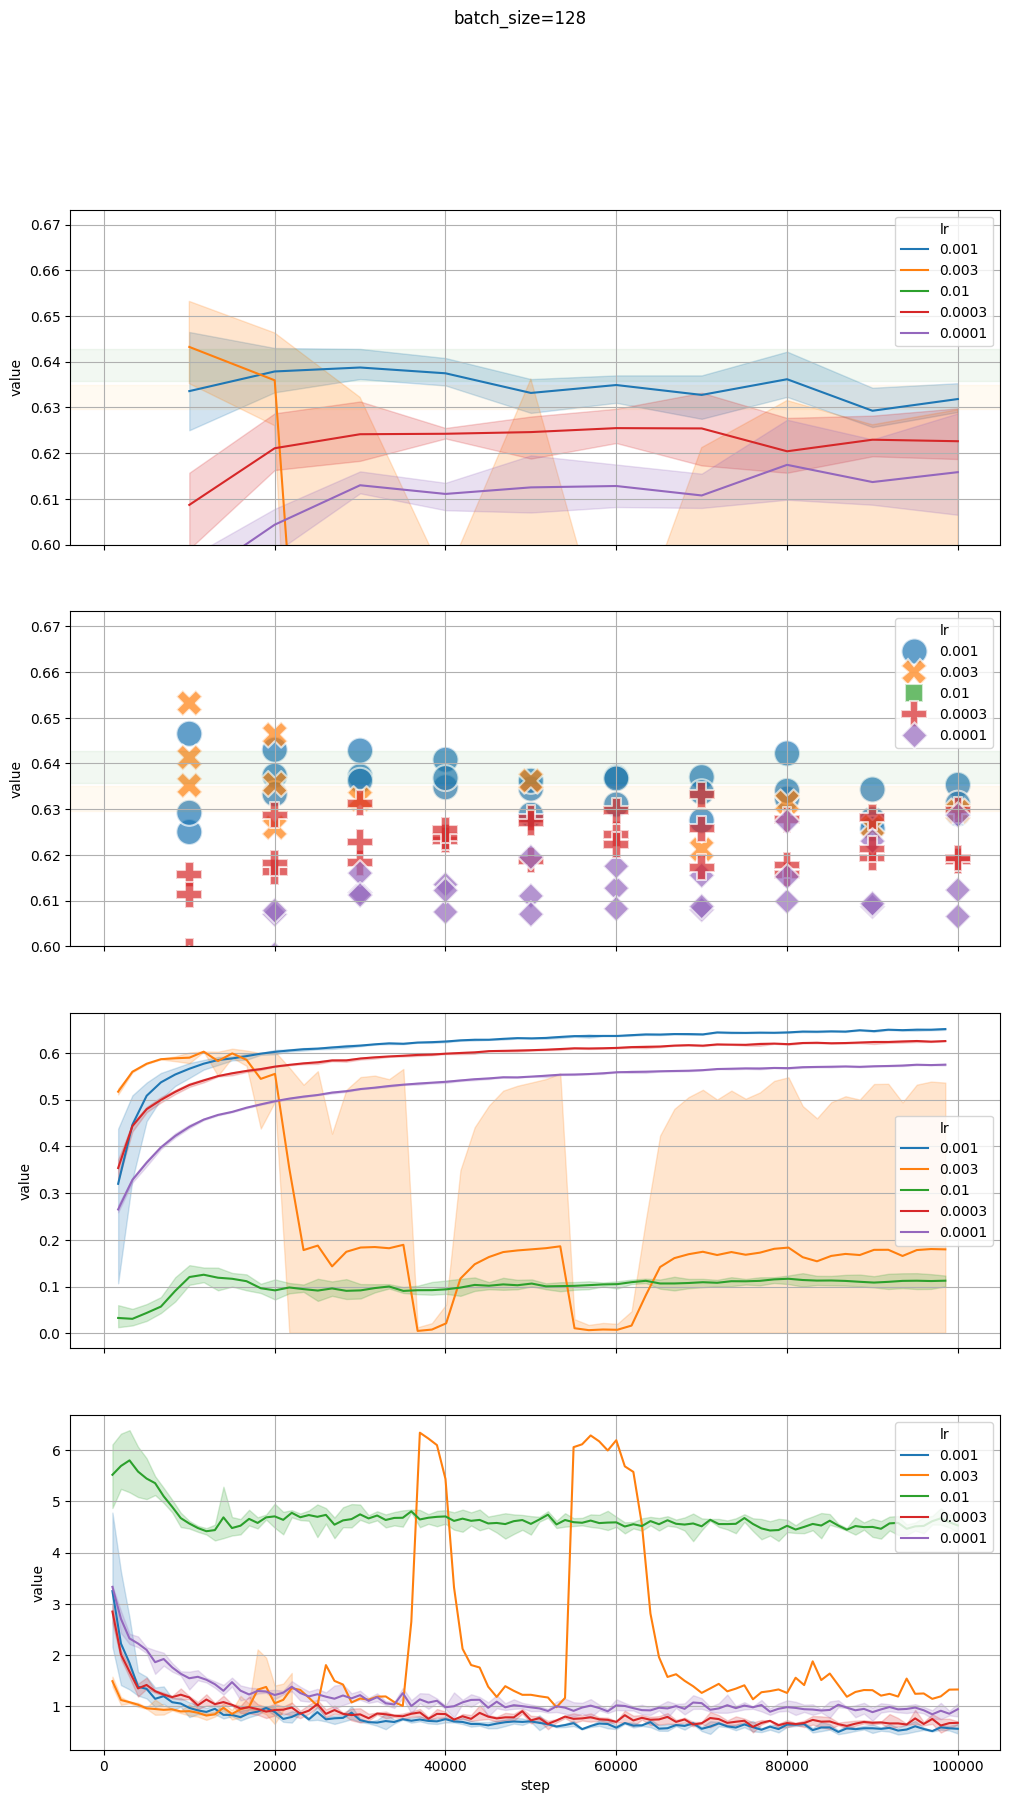

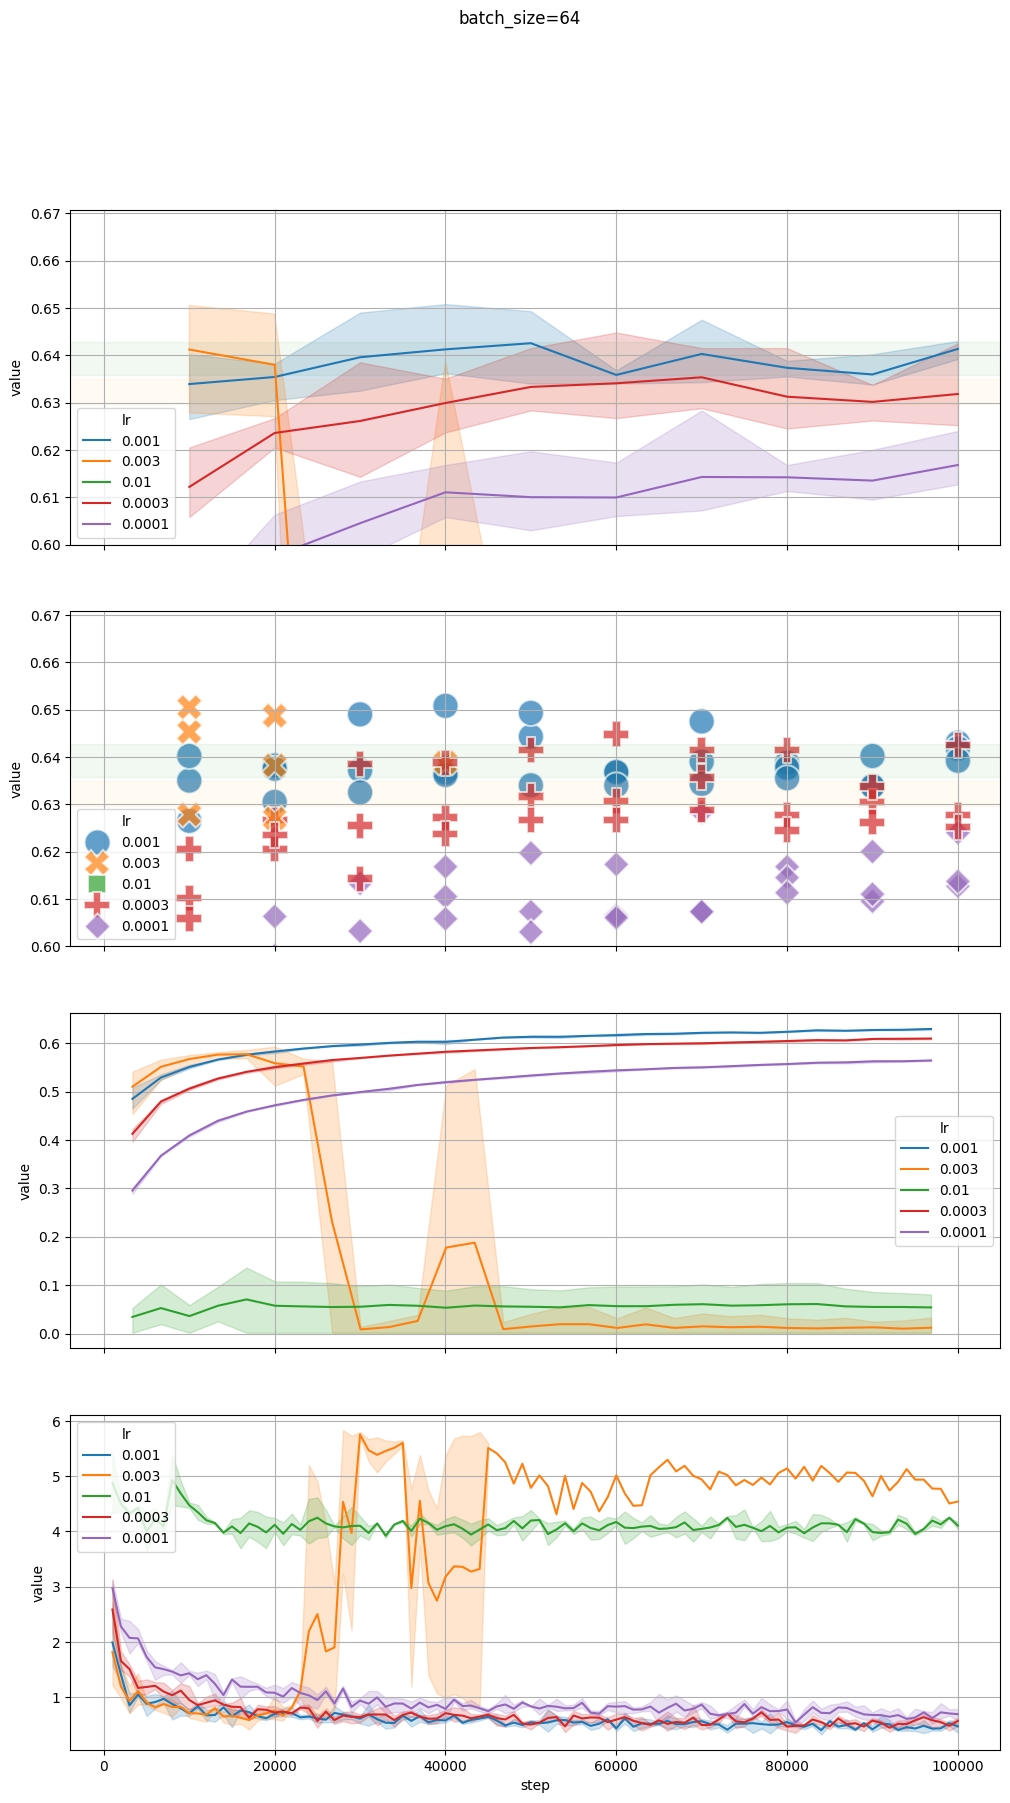

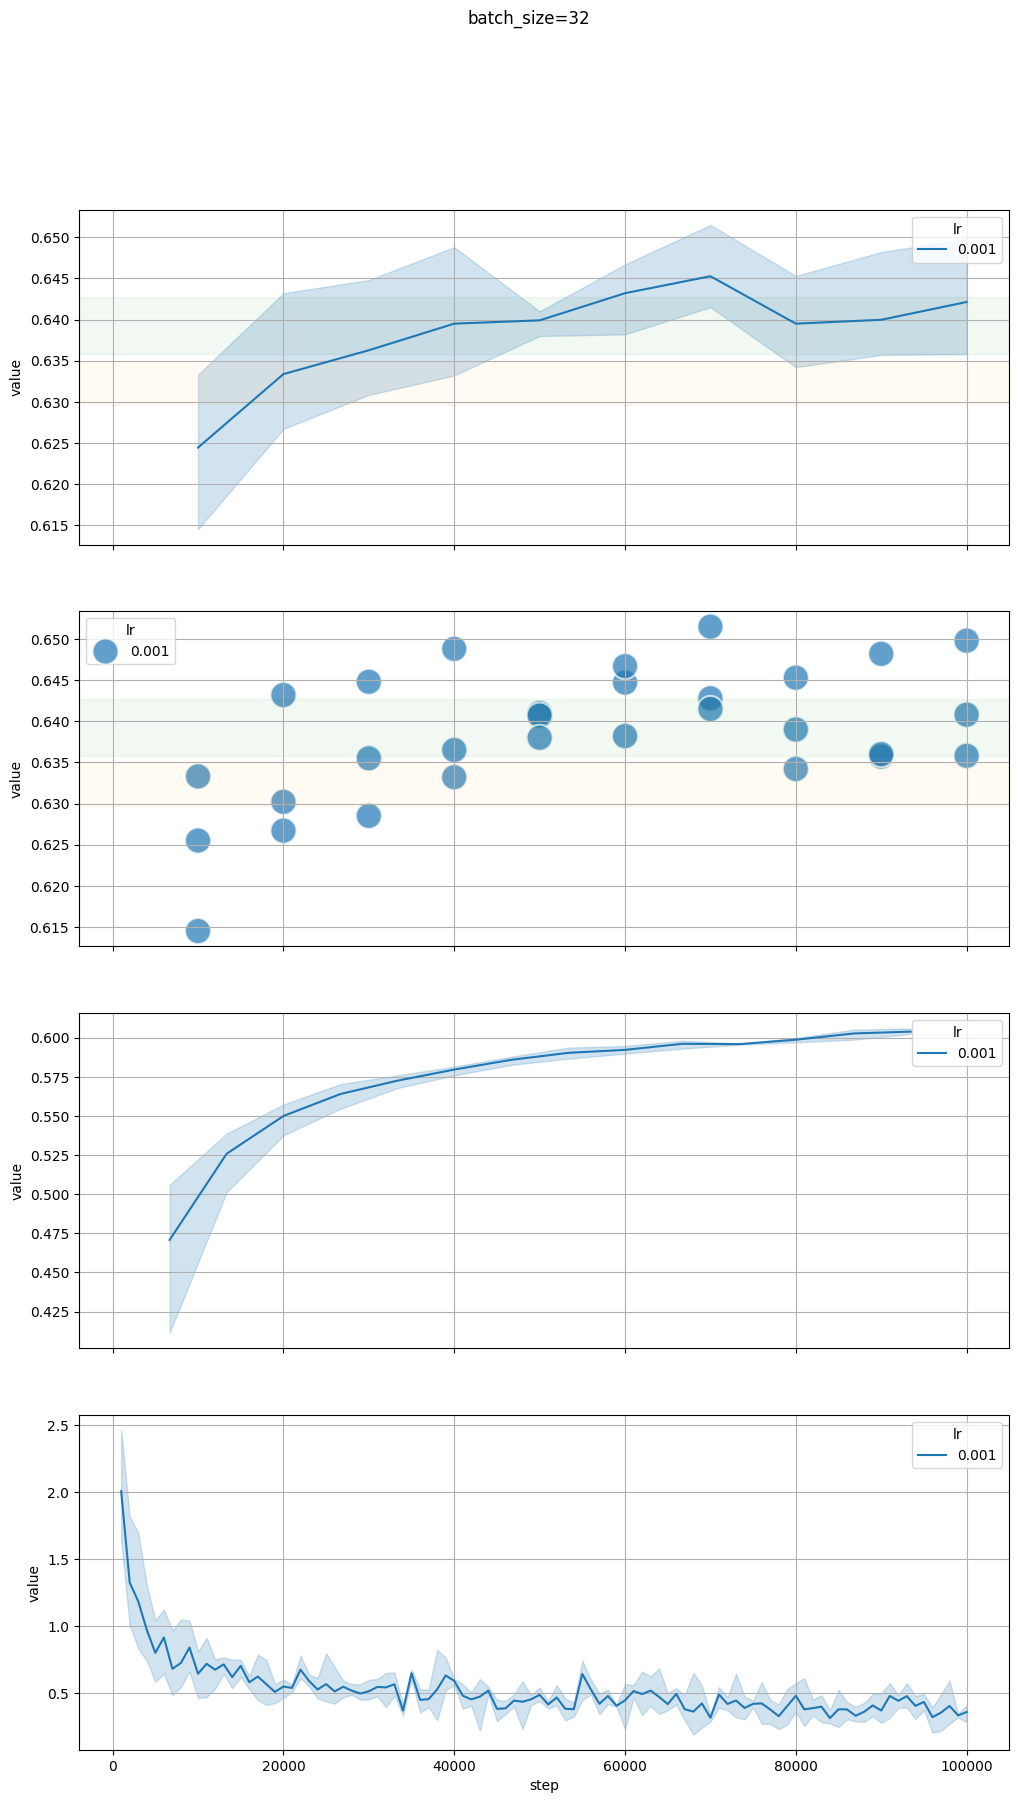

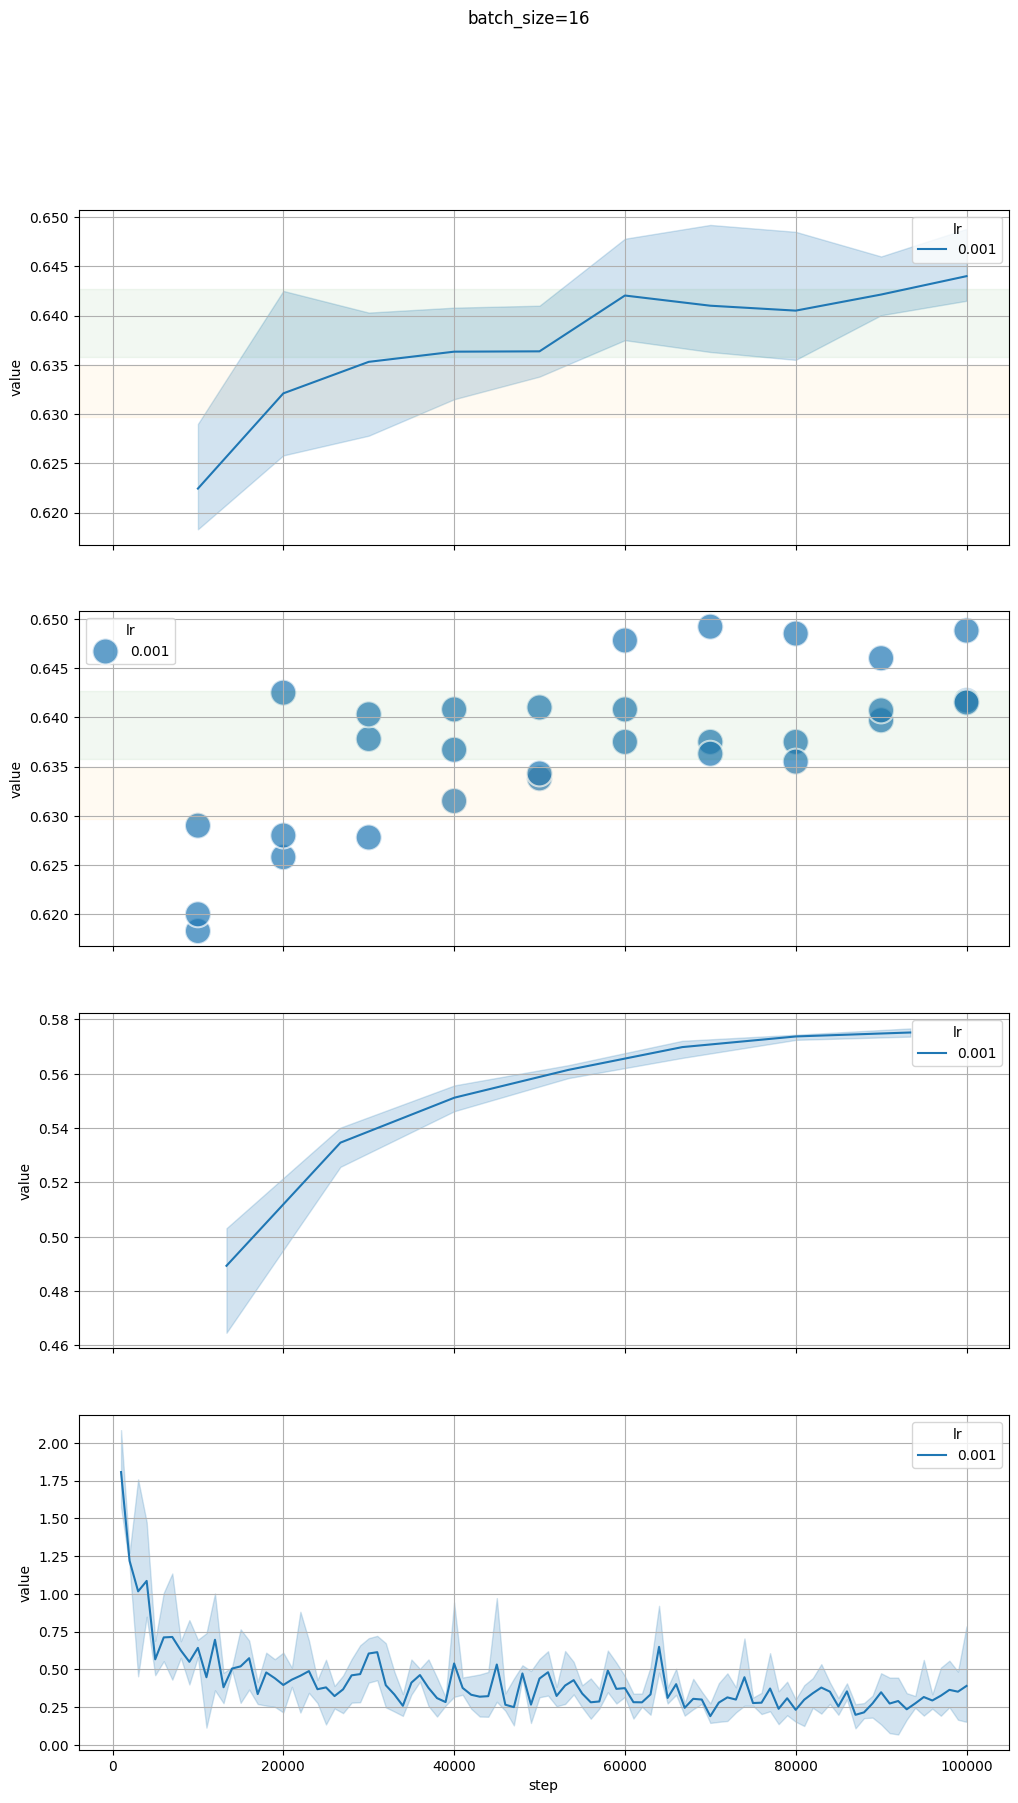

In [169]:
# df_tb = get_scalars('lightning_logs/')
# df_tb = df_tb[lambda x: 
#               x['tag'].eq('valid/recall_top_k') | 
#               x['tag'].eq('loss') & ((x['step'] + 1) % 1000 == 0)]
    
for batch_size in df_res['batch_size'].unique():
    _, axs = plt.subplots(4, 1, figsize=(12, 5 * 4), sharex=True)
    sns.lineplot(
        data=df_res[lambda x: x['batch_size'].eq(batch_size)]
        .assign(lr=lambda x: x['lr'].astype(str)),
        x='train_steps',
        y='value',
        hue='lr',# palette=plt.get_cmap('tab10'),
        ax=axs[0],
    )
    sns.scatterplot(
        data=df_res
        [lambda x: x['batch_size'].eq(batch_size)]
        .assign(lr=lambda x: x['lr'].astype(str)),
        x='train_steps',
        y='value',
        # marker="d",
        hue='lr', #palette=plt.get_cmap('tab10'),
        style='lr',
        # c='k',
        s=350, alpha=0.7,
        ax=axs[1],
    )
    for ax in axs[:2]:
        ax.axhspan(ymin=0.6297, ymax=0.6350, alpha=0.05, color='orange')
        ax.axhspan(ymin=0.6358, ymax=0.6427, alpha=0.05, color='green')
        # ax.axhspan(ymin=0.3845, ymax=0.3872, alpha=0.1, color='red')
        if df_res[lambda x: x['batch_size'].eq(batch_size)]['value'].min() < 0.59:
            ax.set_ylim(0.60, None)

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['batch_size'].eq(batch_size)]
            .groupby('pretrain_logger_version', as_index=False)['lr'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'lr']],
            df_tb[lambda x: x['tag'].eq('valid/recall_top_k')],
            on='version',
        ).assign(lr=lambda x: x['lr'].astype(str)),
        x='step',
        y='value',
        hue='lr',# palette=plt.get_cmap('tab10'),
        ax=axs[2],
    )

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['batch_size'].eq(batch_size)]
            .groupby('pretrain_logger_version', as_index=False)['lr'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'lr']],
            df_tb[lambda x: x['tag'].eq('loss')],  # [lambda x: (x['step'] + 1) % 1000 == 0]
            on='version',
        ).assign(lr=lambda x: x['lr'].astype(str)),
        x='step',
        y='value',
        hue='lr',# palette=plt.get_cmap('tab10'),
        ax=axs[3],
    )
    for ax in axs:
        ax.grid()
        
    plt.suptitle(f'batch_size={batch_size}')
    plt.show()


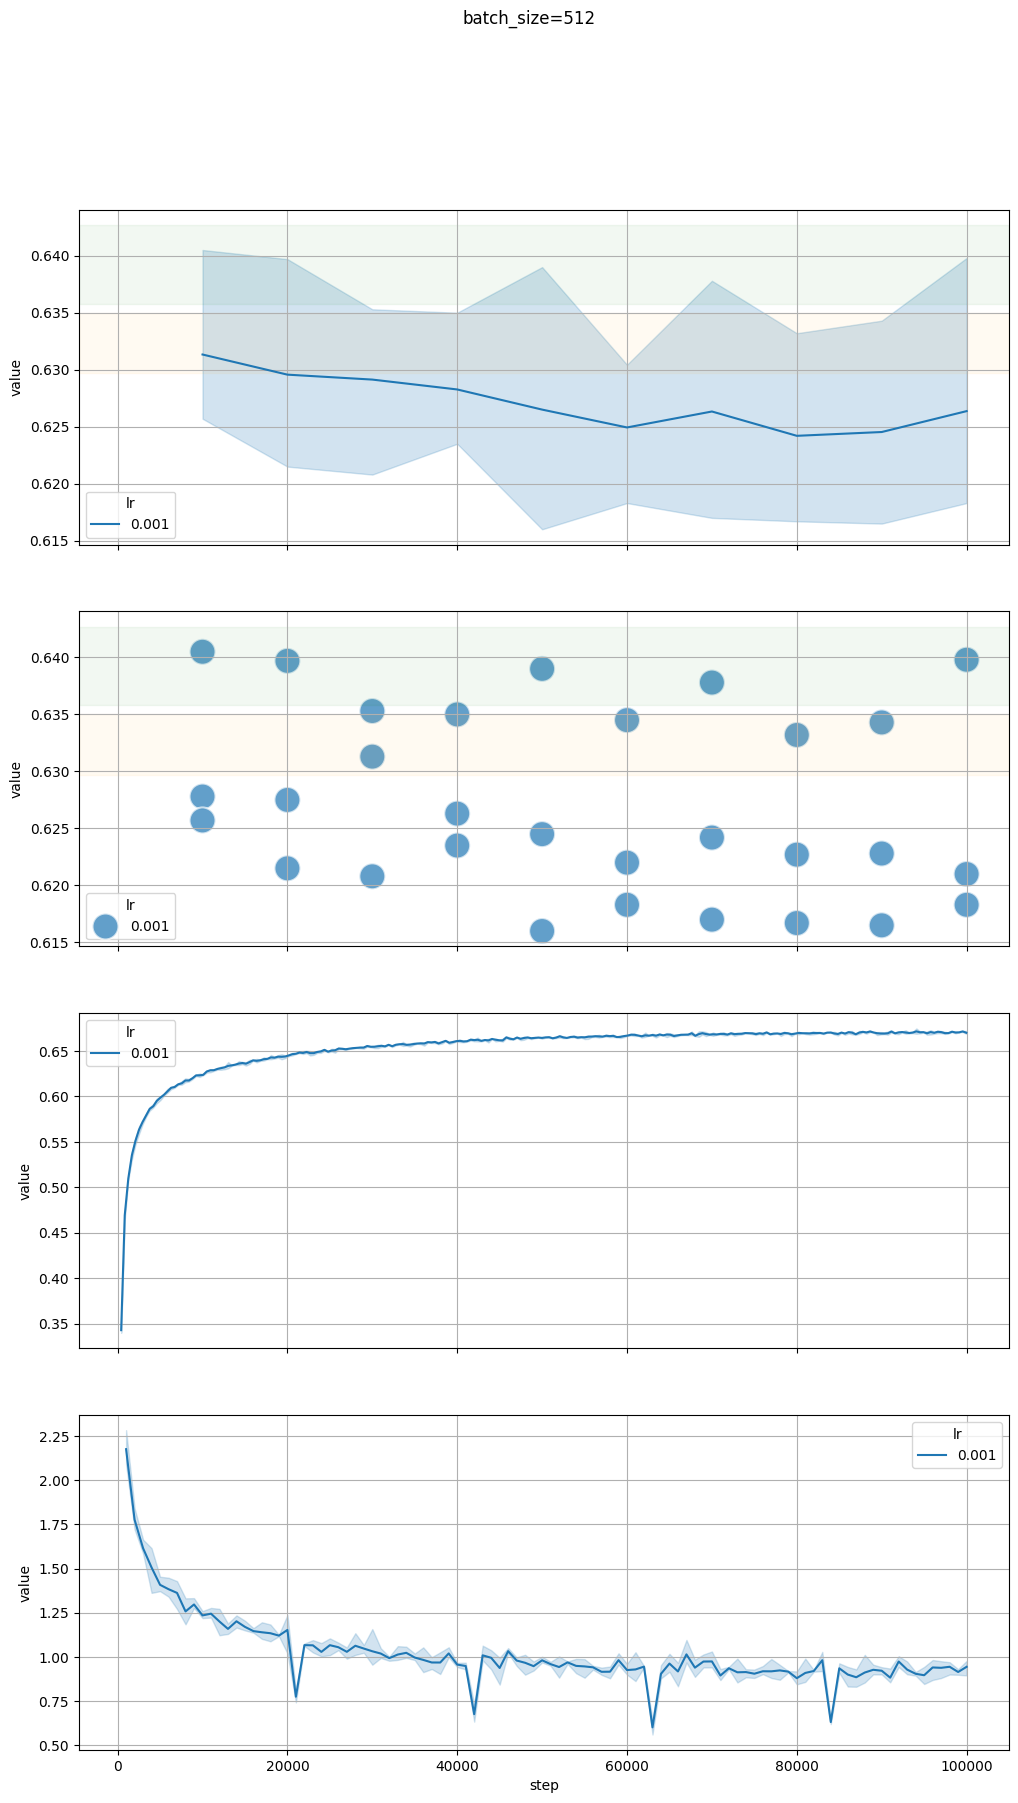

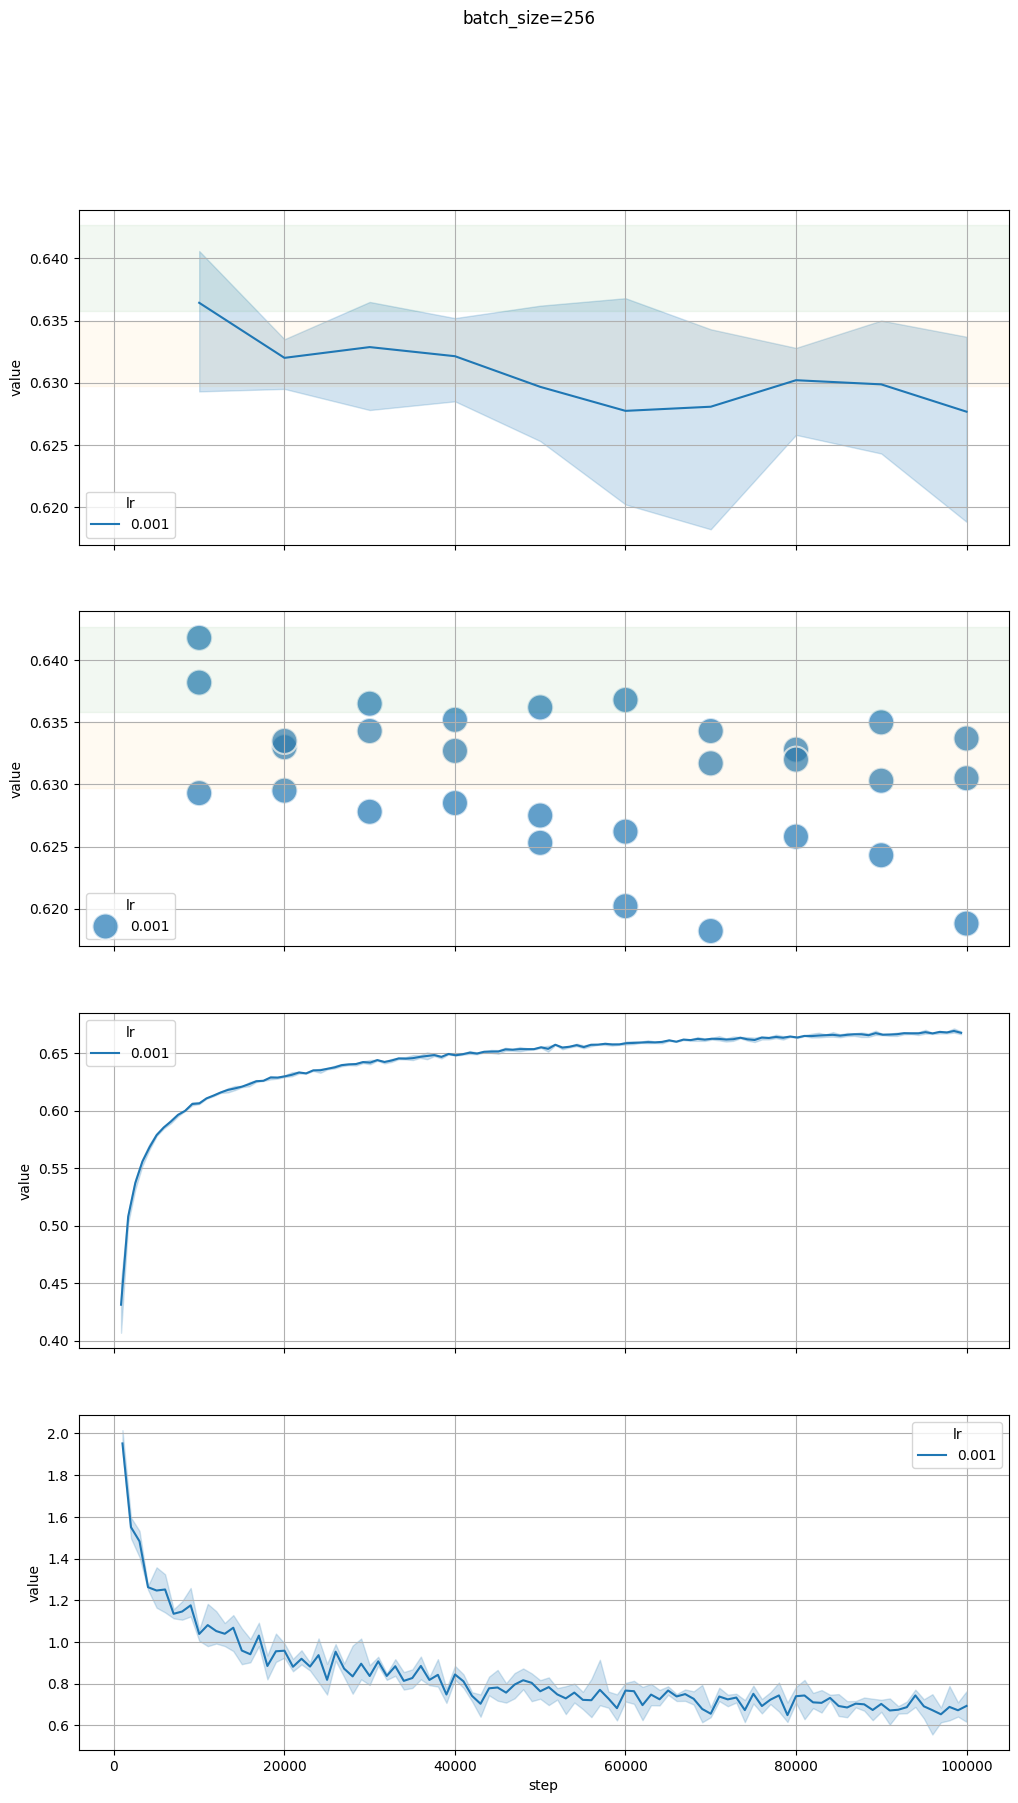

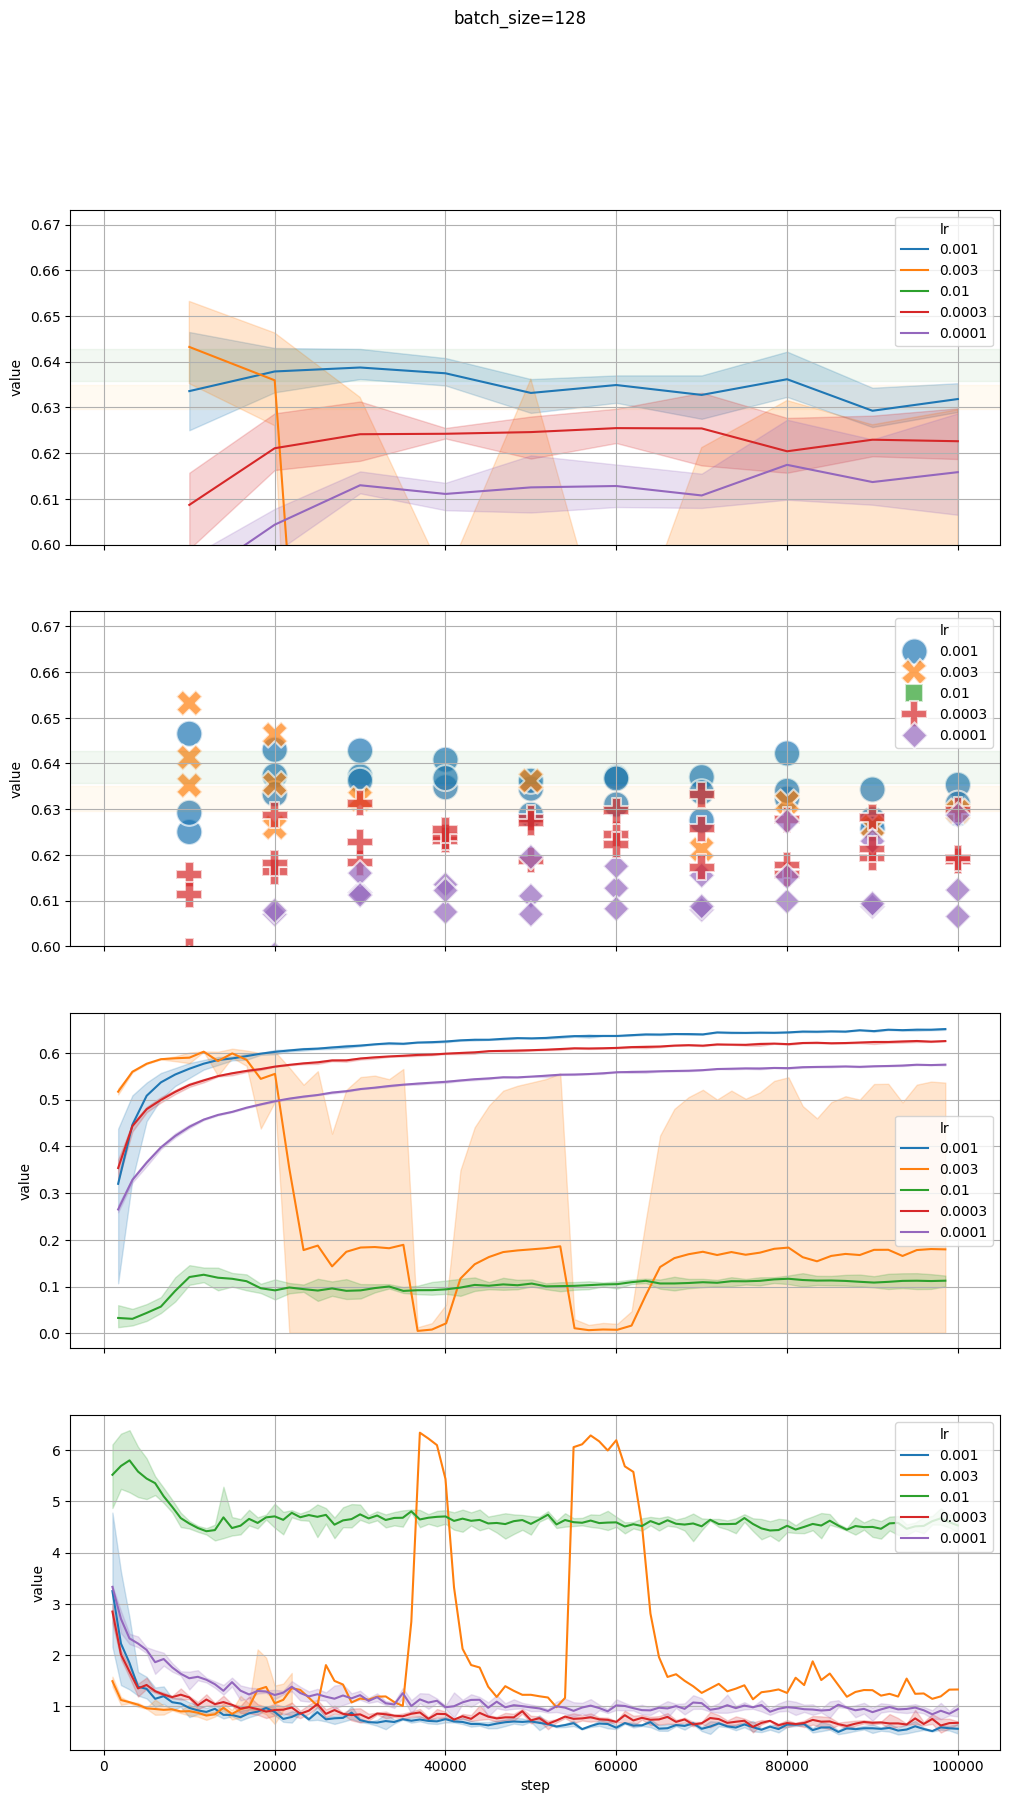

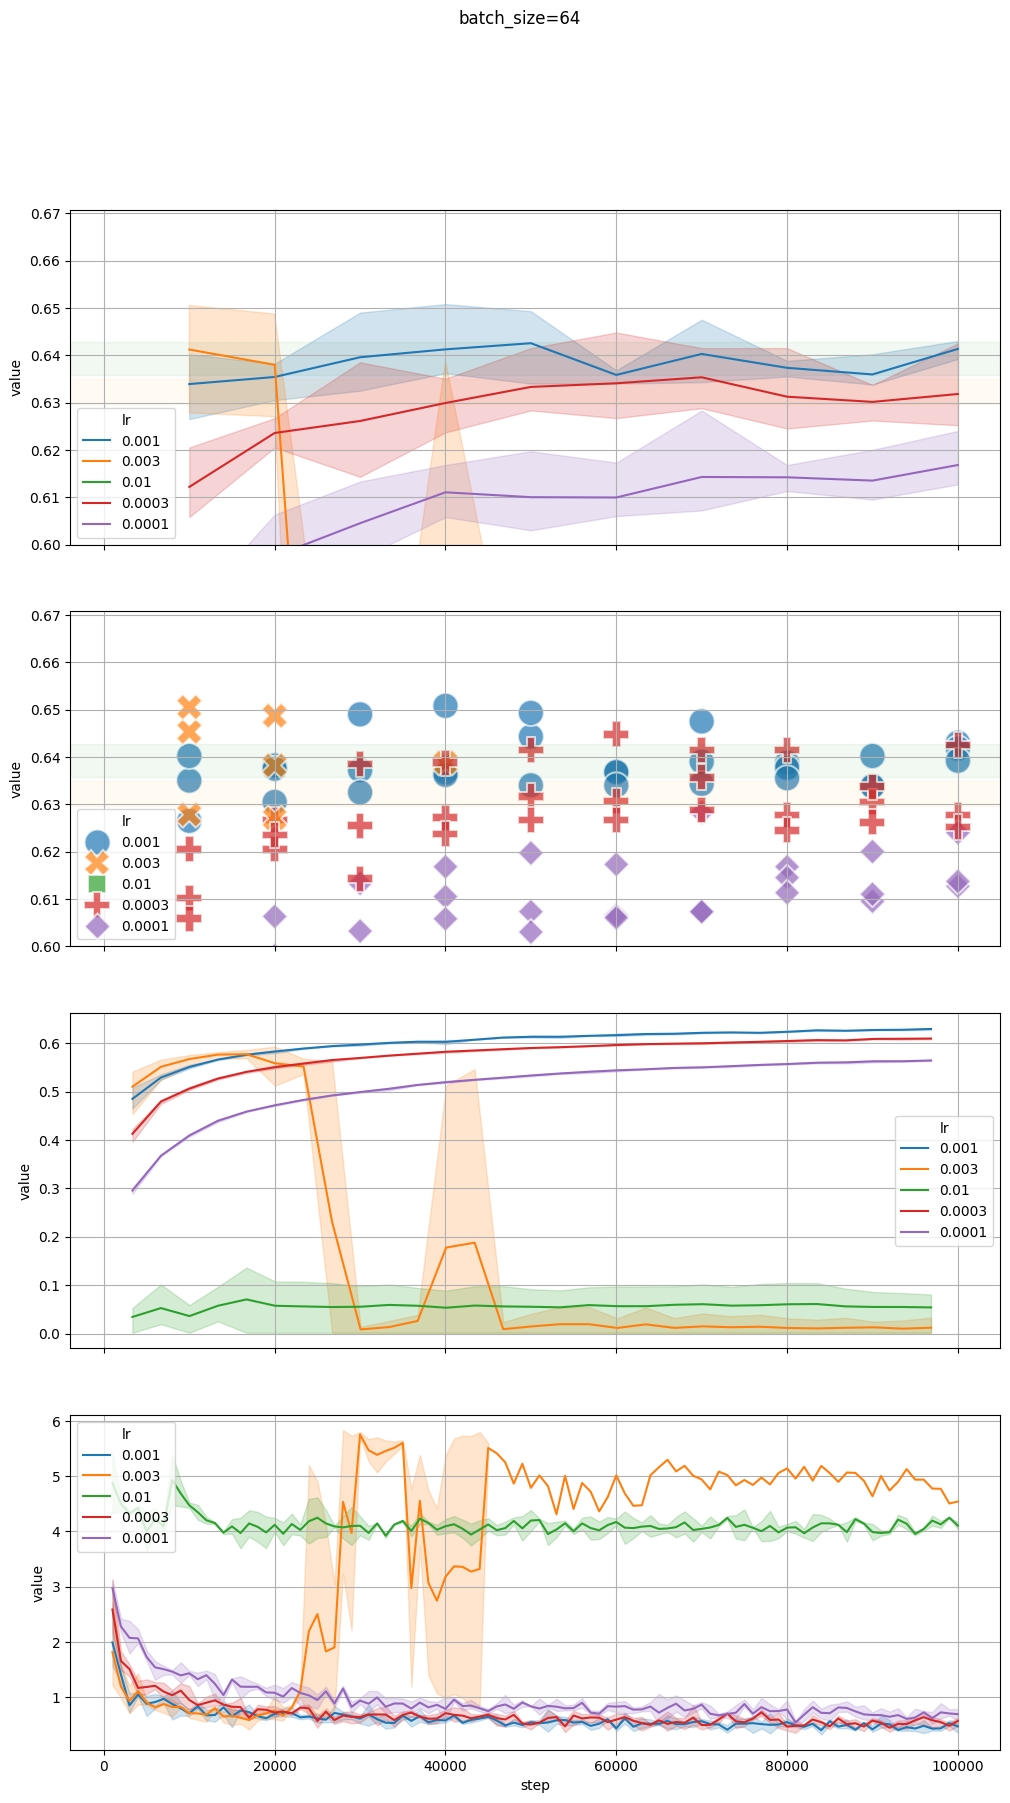

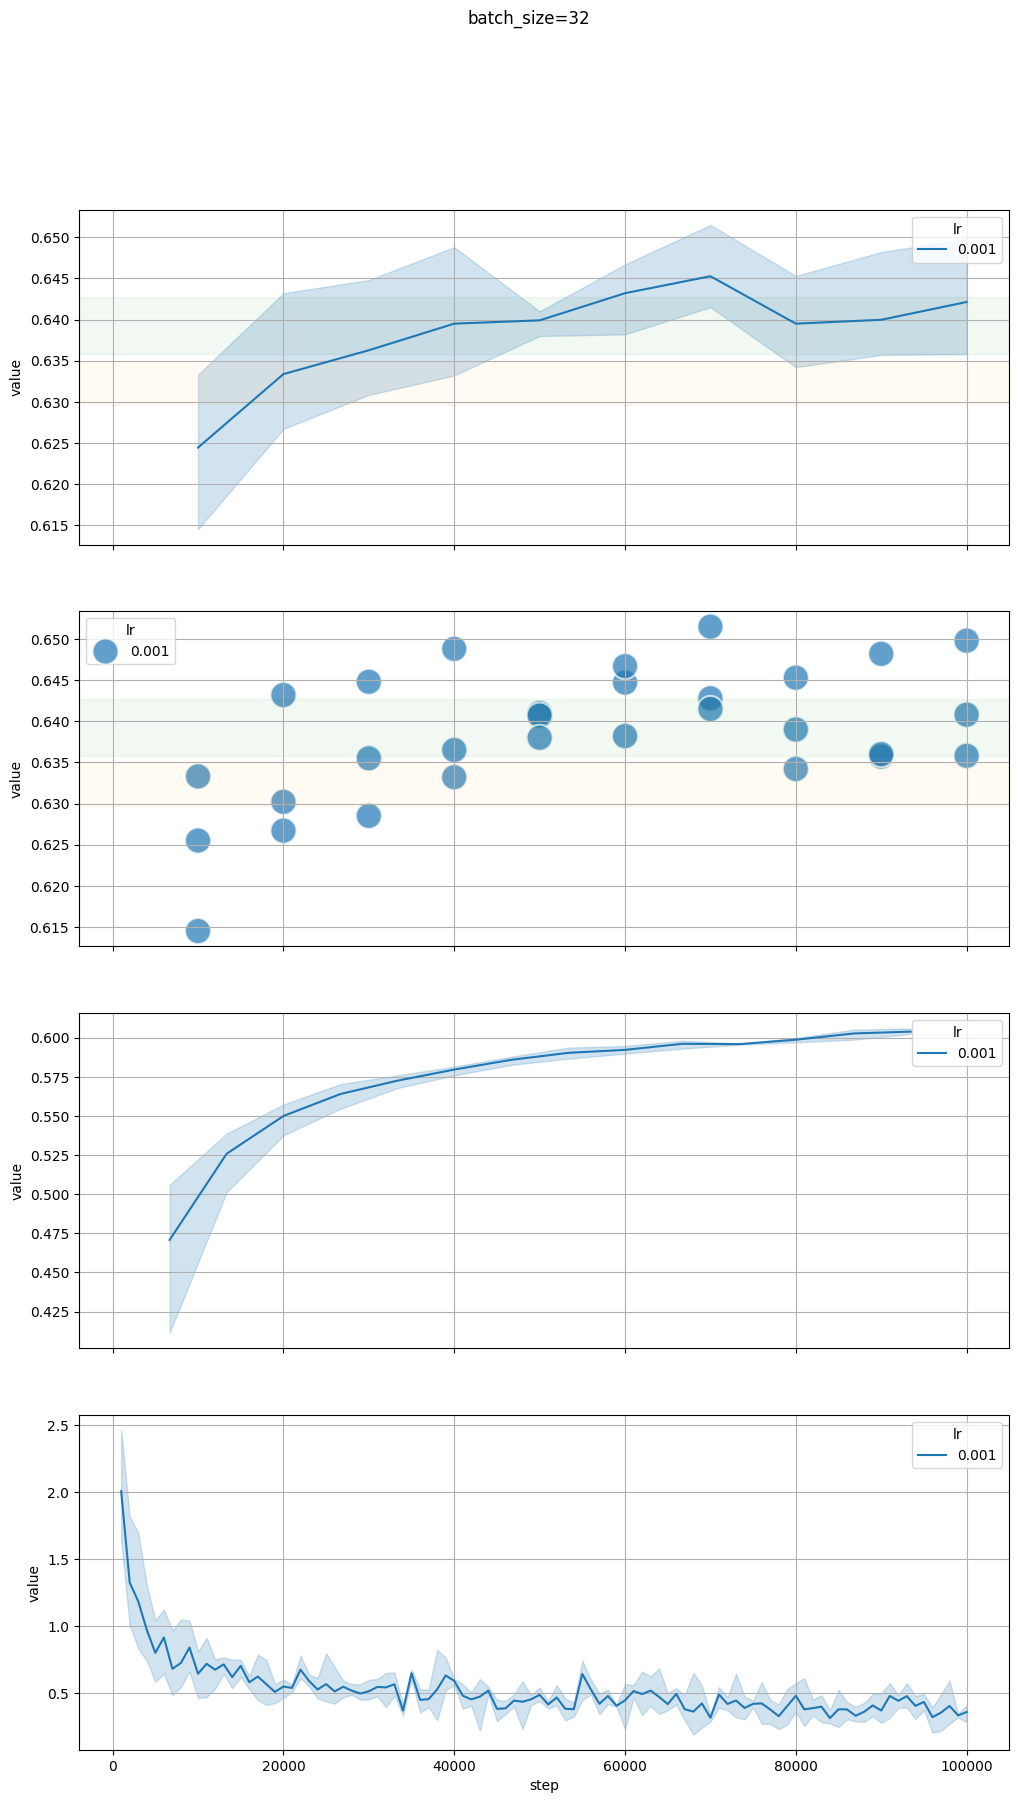

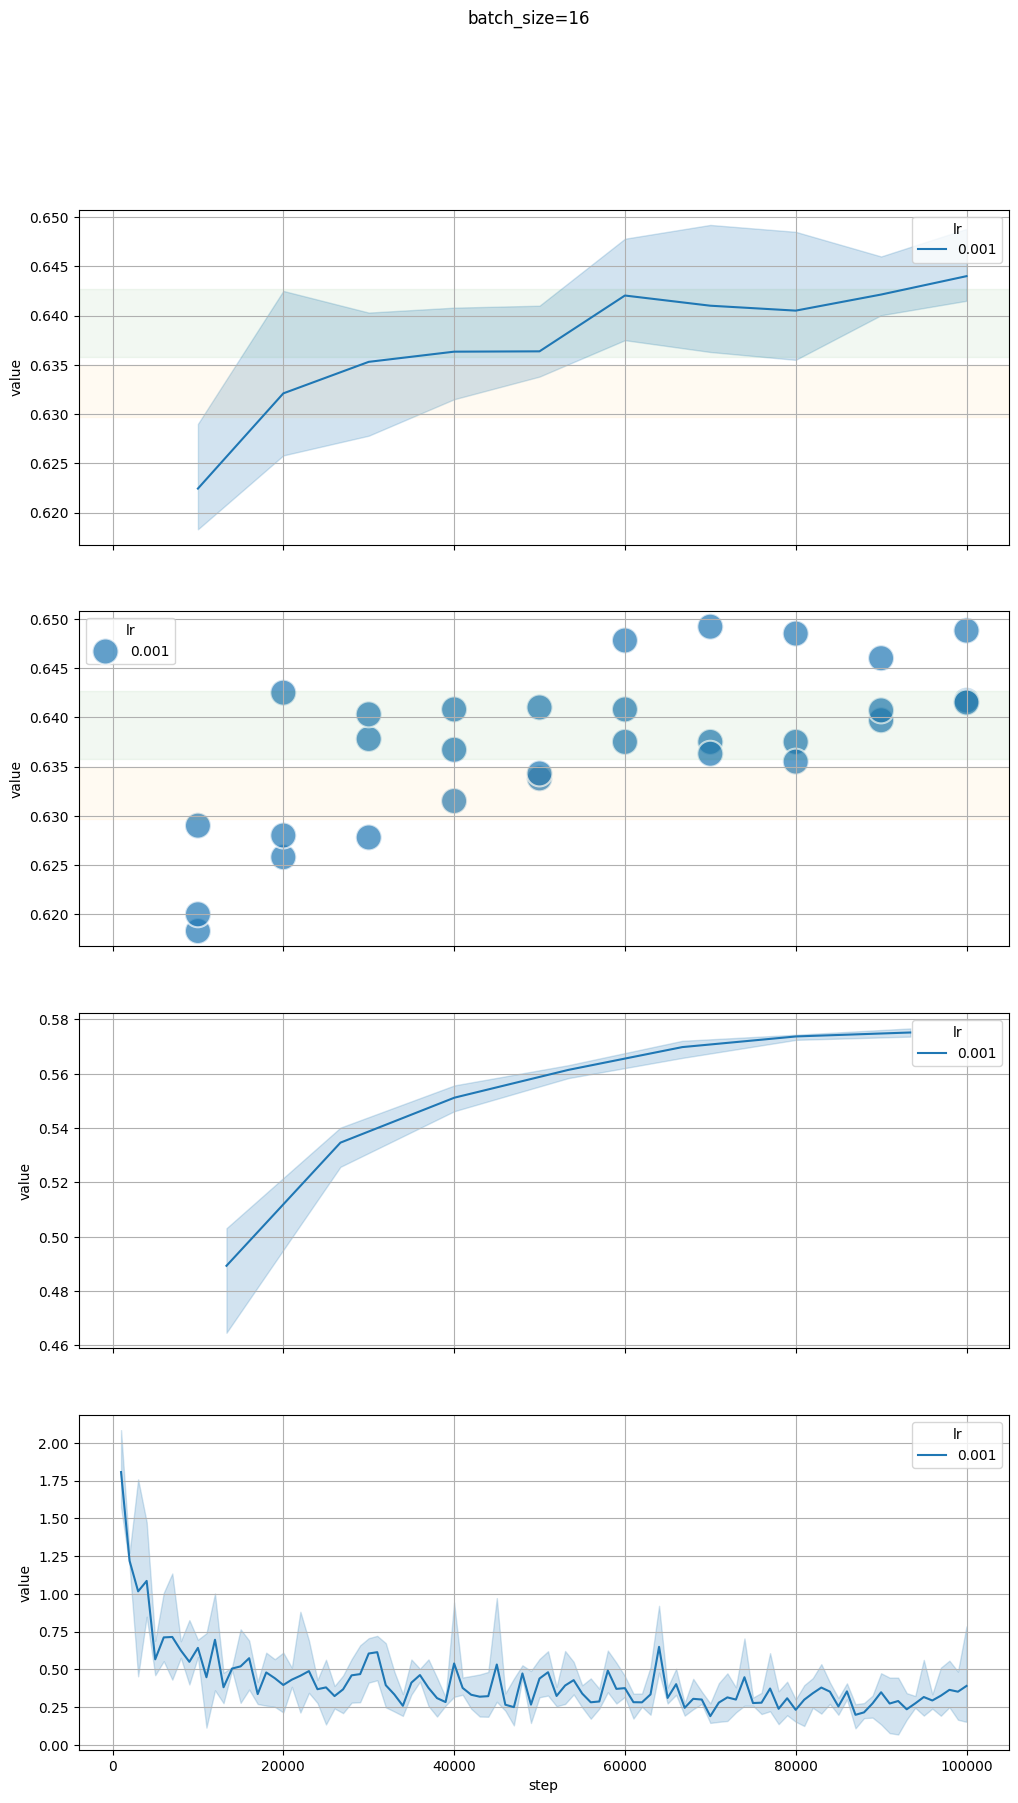

In [169]:
# df_tb = get_scalars('lightning_logs/')
# df_tb = df_tb[lambda x: 
#               x['tag'].eq('valid/recall_top_k') | 
#               x['tag'].eq('loss') & ((x['step'] + 1) % 1000 == 0)]
    
for batch_size in df_res['batch_size'].unique():
    _, axs = plt.subplots(4, 1, figsize=(12, 5 * 4), sharex=True)
    sns.lineplot(
        data=df_res[lambda x: x['batch_size'].eq(batch_size)]
        .assign(lr=lambda x: x['lr'].astype(str)),
        x='train_steps',
        y='value',
        hue='lr',# palette=plt.get_cmap('tab10'),
        ax=axs[0],
    )
    sns.scatterplot(
        data=df_res
        [lambda x: x['batch_size'].eq(batch_size)]
        .assign(lr=lambda x: x['lr'].astype(str)),
        x='train_steps',
        y='value',
        # marker="d",
        hue='lr', #palette=plt.get_cmap('tab10'),
        style='lr',
        # c='k',
        s=350, alpha=0.7,
        ax=axs[1],
    )
    for ax in axs[:2]:
        ax.axhspan(ymin=0.6297, ymax=0.6350, alpha=0.05, color='orange')
        ax.axhspan(ymin=0.6358, ymax=0.6427, alpha=0.05, color='green')
        # ax.axhspan(ymin=0.3845, ymax=0.3872, alpha=0.1, color='red')
        if df_res[lambda x: x['batch_size'].eq(batch_size)]['value'].min() < 0.59:
            ax.set_ylim(0.60, None)

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['batch_size'].eq(batch_size)]
            .groupby('pretrain_logger_version', as_index=False)['lr'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'lr']],
            df_tb[lambda x: x['tag'].eq('valid/recall_top_k')],
            on='version',
        ).assign(lr=lambda x: x['lr'].astype(str)),
        x='step',
        y='value',
        hue='lr',# palette=plt.get_cmap('tab10'),
        ax=axs[2],
    )

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['batch_size'].eq(batch_size)]
            .groupby('pretrain_logger_version', as_index=False)['lr'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'lr']],
            df_tb[lambda x: x['tag'].eq('loss')],  # [lambda x: (x['step'] + 1) % 1000 == 0]
            on='version',
        ).assign(lr=lambda x: x['lr'].astype(str)),
        x='step',
        y='value',
        hue='lr',# palette=plt.get_cmap('tab10'),
        ax=axs[3],
    )
    for ax in axs:
        ax.grid()
        
    plt.suptitle(f'batch_size={batch_size}')
    plt.show()
